In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 40
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_glcm_JointEntropy_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLengthNonUniformityNormalized_glrlm_RunPercentage_glrlm_GrayLevelVariance_glrlm_RunEntropy_glrlm_LowGrayLevelRunEmphasis_glrlm_HighGrayLevelRunEmphasis_glrlm_ShortRunLowGrayLevelEmphasis_glrlm_ShortRunHighGrayLevelEmphasis_glrlm_LongRunLowGrayLevelEmphasis_glrlm_LongRunHighGrayLevelEmphasis_ngtdm_Coarseness_ngtdm_

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 468)
(657450, 8)
validation
(74368, 468)
(74368, 8)
test
(91684, 468)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 468)]             0         


 dense (Dense)               (None, 1024)              480256    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1170312 (4.46 MB)


Trainable params: 1170312 (4.46 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:48 - loss: 2.4438 - STD: 0.0958 - MAE: 0.2245

 3/66 [>.............................] - ETA: 31s - loss: 2.0061 - STD: 0.0881 - MAE: 0.2075 

 6/66 [=>............................] - ETA: 12s - loss: 1.6701 - STD: 0.1382 - MAE: 0.1774

 8/66 [==>...........................] - ETA: 9s - loss: 1.5935 - STD: 0.1645 - MAE: 0.1646 

10/66 [===>..........................] - ETA: 7s - loss: 1.5433 - STD: 0.1806 - MAE: 0.1564

12/66 [====>.........................] - ETA: 6s - loss: 1.5090 - STD: 0.1890 - MAE: 0.1520

14/66 [=====>........................] - ETA: 5s - loss: 1.4843 - STD: 0.1921 - MAE: 0.1500

16/66 [======>.......................] - ETA: 4s - loss: 1.4653 - STD: 0.1924 - MAE: 0.1493

18/66 [=======>......................] - ETA: 4s - loss: 1.4502 - STD: 0.1916 - MAE: 0.1492

20/66 [========>.....................] - ETA: 3s - loss: 1.4387 - STD: 0.1909 - MAE: 0.1491

22/66 [=========>....................] - ETA: 3s - loss: 1.4276 - STD: 0.1908 - MAE: 0.1488

24/66 [=========>....................] - ETA: 3s - loss: 1.4186 - STD: 0.1913 - MAE: 0.1483

26/66 [==========>...................] - ETA: 2s - loss: 1.4118 - STD: 0.1921 - MAE: 0.1478

27/66 [===========>..................] - ETA: 2s - loss: 1.4085 - STD: 0.1926 - MAE: 0.1475

28/66 [===========>..................] - ETA: 2s - loss: 1.4051 - STD: 0.1930 - MAE: 0.1472

30/66 [============>.................] - ETA: 2s - loss: 1.3997 - STD: 0.1938 - MAE: 0.1468

32/66 [=============>................] - ETA: 2s - loss: 1.3955 - STD: 0.1942 - MAE: 0.1466

34/66 [==============>...............] - ETA: 2s - loss: 1.3905 - STD: 0.1943 - MAE: 0.1464

36/66 [===============>..............] - ETA: 1s - loss: 1.3860 - STD: 0.1940 - MAE: 0.1464

38/66 [================>.............] - ETA: 1s - loss: 1.3822 - STD: 0.1935 - MAE: 0.1464

40/66 [=================>............] - ETA: 1s - loss: 1.3795 - STD: 0.1931 - MAE: 0.1465

42/66 [==================>...........] - ETA: 1s - loss: 1.3763 - STD: 0.1928 - MAE: 0.1466

44/66 [===================>..........] - ETA: 1s - loss: 1.3737 - STD: 0.1927 - MAE: 0.1466

46/66 [===================>..........] - ETA: 1s - loss: 1.3704 - STD: 0.1927 - MAE: 0.1465

48/66 [====================>.........] - ETA: 0s - loss: 1.3683 - STD: 0.1928 - MAE: 0.1464

50/66 [=====================>........] - ETA: 0s - loss: 1.3659 - STD: 0.1929 - MAE: 0.1463

52/66 [======================>.......] - ETA: 0s - loss: 1.3639 - STD: 0.1929 - MAE: 0.1462

54/66 [=======================>......] - ETA: 0s - loss: 1.3616 - STD: 0.1929 - MAE: 0.1461

56/66 [========================>.....] - ETA: 0s - loss: 1.3599 - STD: 0.1928 - MAE: 0.1462

58/66 [=========================>....] - ETA: 0s - loss: 1.3586 - STD: 0.1926 - MAE: 0.1462

60/66 [==========================>...] - ETA: 0s - loss: 1.3573 - STD: 0.1924 - MAE: 0.1462

62/66 [===========================>..] - ETA: 0s - loss: 1.3556 - STD: 0.1923 - MAE: 0.1462

64/66 [============================>.] - ETA: 0s - loss: 1.3542 - STD: 0.1923 - MAE: 0.1462

66/66 [==============================] - ETA: 0s - loss: 1.3526 - STD: 0.1922 - MAE: 0.1462

66/66 [==============================] - 5s 59ms/step - loss: 1.3526 - STD: 0.1922 - MAE: 0.1462 - val_loss: 1.2444 - val_STD: 0.1933 - val_MAE: 0.1413


Epoch 2/10000


 1/66 [..............................] - ETA: 3s - loss: 1.3228 - STD: 0.1933 - MAE: 0.1456

 3/66 [>.............................] - ETA: 2s - loss: 1.3165 - STD: 0.1934 - MAE: 0.1450

 5/66 [=>............................] - ETA: 2s - loss: 1.3125 - STD: 0.1934 - MAE: 0.1447

 7/66 [==>...........................] - ETA: 1s - loss: 1.3118 - STD: 0.1933 - MAE: 0.1447

 9/66 [===>..........................] - ETA: 1s - loss: 1.3135 - STD: 0.1931 - MAE: 0.1448

11/66 [====>.........................] - ETA: 1s - loss: 1.3140 - STD: 0.1929 - MAE: 0.1450

13/66 [====>.........................] - ETA: 1s - loss: 1.3132 - STD: 0.1925 - MAE: 0.1451

15/66 [=====>........................] - ETA: 1s - loss: 1.3136 - STD: 0.1921 - MAE: 0.1453

17/66 [======>.......................] - ETA: 1s - loss: 1.3136 - STD: 0.1917 - MAE: 0.1455

19/66 [=======>......................] - ETA: 1s - loss: 1.3119 - STD: 0.1915 - MAE: 0.1455

21/66 [========>.....................] - ETA: 1s - loss: 1.3118 - STD: 0.1915 - MAE: 0.1454

22/66 [=========>....................] - ETA: 1s - loss: 1.3124 - STD: 0.1916 - MAE: 0.1455

23/66 [=========>....................] - ETA: 1s - loss: 1.3118 - STD: 0.1916 - MAE: 0.1454

25/66 [==========>...................] - ETA: 1s - loss: 1.3103 - STD: 0.1918 - MAE: 0.1453

27/66 [===========>..................] - ETA: 1s - loss: 1.3094 - STD: 0.1920 - MAE: 0.1451

29/66 [============>.................] - ETA: 1s - loss: 1.3089 - STD: 0.1922 - MAE: 0.1450

31/66 [=============>................] - ETA: 1s - loss: 1.3093 - STD: 0.1923 - MAE: 0.1450

33/66 [==============>...............] - ETA: 1s - loss: 1.3085 - STD: 0.1923 - MAE: 0.1450

35/66 [==============>...............] - ETA: 1s - loss: 1.3077 - STD: 0.1923 - MAE: 0.1449

37/66 [===============>..............] - ETA: 1s - loss: 1.3079 - STD: 0.1923 - MAE: 0.1449

39/66 [================>.............] - ETA: 0s - loss: 1.3072 - STD: 0.1923 - MAE: 0.1449

41/66 [=================>............] - ETA: 0s - loss: 1.3069 - STD: 0.1923 - MAE: 0.1449

43/66 [==================>...........] - ETA: 0s - loss: 1.3068 - STD: 0.1923 - MAE: 0.1448

45/66 [===================>..........] - ETA: 0s - loss: 1.3067 - STD: 0.1924 - MAE: 0.1448

47/66 [====================>.........] - ETA: 0s - loss: 1.3071 - STD: 0.1924 - MAE: 0.1449

49/66 [=====================>........] - ETA: 0s - loss: 1.3073 - STD: 0.1923 - MAE: 0.1449

51/66 [======================>.......] - ETA: 0s - loss: 1.3072 - STD: 0.1923 - MAE: 0.1449

53/66 [=======================>......] - ETA: 0s - loss: 1.3078 - STD: 0.1923 - MAE: 0.1449

55/66 [========================>.....] - ETA: 0s - loss: 1.3078 - STD: 0.1923 - MAE: 0.1449

57/66 [========================>.....] - ETA: 0s - loss: 1.3080 - STD: 0.1923 - MAE: 0.1449

59/66 [=========================>....] - ETA: 0s - loss: 1.3080 - STD: 0.1923 - MAE: 0.1449

61/66 [==========================>...] - ETA: 0s - loss: 1.3087 - STD: 0.1922 - MAE: 0.1450

63/66 [===========================>..] - ETA: 0s - loss: 1.3083 - STD: 0.1921 - MAE: 0.1450

65/66 [============================>.] - ETA: 0s - loss: 1.3082 - STD: 0.1920 - MAE: 0.1450

66/66 [==============================] - 2s 37ms/step - loss: 1.3082 - STD: 0.1920 - MAE: 0.1450 - val_loss: 1.2435 - val_STD: 0.1941 - val_MAE: 0.1409


Epoch 3/10000


 1/66 [..............................] - ETA: 3s - loss: 1.2871 - STD: 0.1941 - MAE: 0.1432

 3/66 [>.............................] - ETA: 2s - loss: 1.2962 - STD: 0.1951 - MAE: 0.1432

 5/66 [=>............................] - ETA: 2s - loss: 1.2976 - STD: 0.1955 - MAE: 0.1431

 6/66 [=>............................] - ETA: 2s - loss: 1.3020 - STD: 0.1955 - MAE: 0.1433

 7/66 [==>...........................] - ETA: 2s - loss: 1.3021 - STD: 0.1953 - MAE: 0.1434

 9/66 [===>..........................] - ETA: 2s - loss: 1.3008 - STD: 0.1946 - MAE: 0.1436

11/66 [====>.........................] - ETA: 2s - loss: 1.2998 - STD: 0.1939 - MAE: 0.1438

13/66 [====>.........................] - ETA: 2s - loss: 1.3016 - STD: 0.1935 - MAE: 0.1441

15/66 [=====>........................] - ETA: 1s - loss: 1.3023 - STD: 0.1933 - MAE: 0.1442

17/66 [======>.......................] - ETA: 1s - loss: 1.3038 - STD: 0.1933 - MAE: 0.1443

19/66 [=======>......................] - ETA: 1s - loss: 1.3036 - STD: 0.1931 - MAE: 0.1443

21/66 [========>.....................] - ETA: 1s - loss: 1.3038 - STD: 0.1930 - MAE: 0.1444

23/66 [=========>....................] - ETA: 1s - loss: 1.3036 - STD: 0.1928 - MAE: 0.1444

25/66 [==========>...................] - ETA: 1s - loss: 1.3040 - STD: 0.1928 - MAE: 0.1445

27/66 [===========>..................] - ETA: 1s - loss: 1.3042 - STD: 0.1927 - MAE: 0.1445

29/66 [============>.................] - ETA: 1s - loss: 1.3040 - STD: 0.1927 - MAE: 0.1445

31/66 [=============>................] - ETA: 1s - loss: 1.3040 - STD: 0.1927 - MAE: 0.1445

33/66 [==============>...............] - ETA: 1s - loss: 1.3035 - STD: 0.1928 - MAE: 0.1445

35/66 [==============>...............] - ETA: 1s - loss: 1.3047 - STD: 0.1928 - MAE: 0.1445

37/66 [===============>..............] - ETA: 1s - loss: 1.3043 - STD: 0.1927 - MAE: 0.1445

39/66 [================>.............] - ETA: 0s - loss: 1.3044 - STD: 0.1927 - MAE: 0.1445

41/66 [=================>............] - ETA: 0s - loss: 1.3051 - STD: 0.1926 - MAE: 0.1446

43/66 [==================>...........] - ETA: 0s - loss: 1.3048 - STD: 0.1925 - MAE: 0.1446

45/66 [===================>..........] - ETA: 0s - loss: 1.3046 - STD: 0.1924 - MAE: 0.1446

47/66 [====================>.........] - ETA: 0s - loss: 1.3044 - STD: 0.1924 - MAE: 0.1446

49/66 [=====================>........] - ETA: 0s - loss: 1.3048 - STD: 0.1925 - MAE: 0.1446

51/66 [======================>.......] - ETA: 0s - loss: 1.3049 - STD: 0.1925 - MAE: 0.1446

53/66 [=======================>......] - ETA: 0s - loss: 1.3051 - STD: 0.1924 - MAE: 0.1447

55/66 [========================>.....] - ETA: 0s - loss: 1.3053 - STD: 0.1922 - MAE: 0.1448

57/66 [========================>.....] - ETA: 0s - loss: 1.3055 - STD: 0.1921 - MAE: 0.1448

59/66 [=========================>....] - ETA: 0s - loss: 1.3056 - STD: 0.1920 - MAE: 0.1449

61/66 [==========================>...] - ETA: 0s - loss: 1.3051 - STD: 0.1919 - MAE: 0.1449

63/66 [===========================>..] - ETA: 0s - loss: 1.3048 - STD: 0.1919 - MAE: 0.1449

65/66 [============================>.] - ETA: 0s - loss: 1.3041 - STD: 0.1919 - MAE: 0.1448

66/66 [==============================] - 2s 37ms/step - loss: 1.3041 - STD: 0.1920 - MAE: 0.1448 - val_loss: 1.2183 - val_STD: 0.1922 - val_MAE: 0.1403


Epoch 4/10000


 1/66 [..............................] - ETA: 3s - loss: 1.2792 - STD: 0.1928 - MAE: 0.1433

 3/66 [>.............................] - ETA: 2s - loss: 1.2786 - STD: 0.1925 - MAE: 0.1434

 5/66 [=>............................] - ETA: 2s - loss: 1.2776 - STD: 0.1917 - MAE: 0.1436

 7/66 [==>...........................] - ETA: 1s - loss: 1.2731 - STD: 0.1919 - MAE: 0.1433

 9/66 [===>..........................] - ETA: 1s - loss: 1.2736 - STD: 0.1923 - MAE: 0.1431

11/66 [====>.........................] - ETA: 1s - loss: 1.2743 - STD: 0.1924 - MAE: 0.1432

13/66 [====>.........................] - ETA: 1s - loss: 1.2739 - STD: 0.1922 - MAE: 0.1432

15/66 [=====>........................] - ETA: 1s - loss: 1.2742 - STD: 0.1928 - MAE: 0.1430

17/66 [======>.......................] - ETA: 1s - loss: 1.2717 - STD: 0.1927 - MAE: 0.1429

19/66 [=======>......................] - ETA: 1s - loss: 1.2711 - STD: 0.1928 - MAE: 0.1428

21/66 [========>.....................] - ETA: 1s - loss: 1.2688 - STD: 0.1933 - MAE: 0.1425

23/66 [=========>....................] - ETA: 1s - loss: 1.2674 - STD: 0.1934 - MAE: 0.1424

25/66 [==========>...................] - ETA: 1s - loss: 1.2650 - STD: 0.1935 - MAE: 0.1423

27/66 [===========>..................] - ETA: 1s - loss: 1.2632 - STD: 0.1938 - MAE: 0.1421

29/66 [============>.................] - ETA: 1s - loss: 1.2607 - STD: 0.1937 - MAE: 0.1421

31/66 [=============>................] - ETA: 1s - loss: 1.2590 - STD: 0.1942 - MAE: 0.1419

33/66 [==============>...............] - ETA: 1s - loss: 1.2569 - STD: 0.1941 - MAE: 0.1418

35/66 [==============>...............] - ETA: 1s - loss: 1.2551 - STD: 0.1946 - MAE: 0.1416

37/66 [===============>..............] - ETA: 0s - loss: 1.2537 - STD: 0.1946 - MAE: 0.1416

39/66 [================>.............] - ETA: 0s - loss: 1.2523 - STD: 0.1949 - MAE: 0.1414

41/66 [=================>............] - ETA: 0s - loss: 1.2502 - STD: 0.1950 - MAE: 0.1414

43/66 [==================>...........] - ETA: 0s - loss: 1.2485 - STD: 0.1950 - MAE: 0.1413

45/66 [===================>..........] - ETA: 0s - loss: 1.2464 - STD: 0.1953 - MAE: 0.1411

47/66 [====================>.........] - ETA: 0s - loss: 1.2444 - STD: 0.1953 - MAE: 0.1411

49/66 [=====================>........] - ETA: 0s - loss: 1.2427 - STD: 0.1956 - MAE: 0.1409

51/66 [======================>.......] - ETA: 0s - loss: 1.2403 - STD: 0.1957 - MAE: 0.1408

53/66 [=======================>......] - ETA: 0s - loss: 1.2385 - STD: 0.1959 - MAE: 0.1407

55/66 [========================>.....] - ETA: 0s - loss: 1.2369 - STD: 0.1960 - MAE: 0.1406

57/66 [========================>.....] - ETA: 0s - loss: 1.2355 - STD: 0.1962 - MAE: 0.1405

59/66 [=========================>....] - ETA: 0s - loss: 1.2340 - STD: 0.1963 - MAE: 0.1405

61/66 [==========================>...] - ETA: 0s - loss: 1.2320 - STD: 0.1964 - MAE: 0.1404

63/66 [===========================>..] - ETA: 0s - loss: 1.2303 - STD: 0.1965 - MAE: 0.1403

65/66 [============================>.] - ETA: 0s - loss: 1.2289 - STD: 0.1966 - MAE: 0.1402

66/66 [==============================] - 2s 37ms/step - loss: 1.2283 - STD: 0.1967 - MAE: 0.1402 - val_loss: 1.0958 - val_STD: 0.1953 - val_MAE: 0.1345


Epoch 5/10000


 1/66 [..............................] - ETA: 4s - loss: 1.1959 - STD: 0.2034 - MAE: 0.1375

 2/66 [..............................] - ETA: 3s - loss: 1.1894 - STD: 0.1997 - MAE: 0.1385

 3/66 [>.............................] - ETA: 3s - loss: 1.1794 - STD: 0.1996 - MAE: 0.1380

 4/66 [>.............................] - ETA: 3s - loss: 1.1806 - STD: 0.2009 - MAE: 0.1375

 6/66 [=>............................] - ETA: 2s - loss: 1.1771 - STD: 0.1996 - MAE: 0.1379

 8/66 [==>...........................] - ETA: 2s - loss: 1.1757 - STD: 0.2008 - MAE: 0.1374

10/66 [===>..........................] - ETA: 2s - loss: 1.1735 - STD: 0.1999 - MAE: 0.1376

12/66 [====>.........................] - ETA: 2s - loss: 1.1740 - STD: 0.2013 - MAE: 0.1371

14/66 [=====>........................] - ETA: 2s - loss: 1.1731 - STD: 0.2008 - MAE: 0.1373

16/66 [======>.......................] - ETA: 2s - loss: 1.1734 - STD: 0.2013 - MAE: 0.1371

18/66 [=======>......................] - ETA: 1s - loss: 1.1737 - STD: 0.2003 - MAE: 0.1375

20/66 [========>.....................] - ETA: 1s - loss: 1.1718 - STD: 0.2008 - MAE: 0.1372

22/66 [=========>....................] - ETA: 1s - loss: 1.1708 - STD: 0.2007 - MAE: 0.1372

24/66 [=========>....................] - ETA: 1s - loss: 1.1712 - STD: 0.2013 - MAE: 0.1371

26/66 [==========>...................] - ETA: 1s - loss: 1.1698 - STD: 0.2009 - MAE: 0.1372

28/66 [===========>..................] - ETA: 1s - loss: 1.1685 - STD: 0.2011 - MAE: 0.1371

30/66 [============>.................] - ETA: 1s - loss: 1.1681 - STD: 0.2008 - MAE: 0.1372

32/66 [=============>................] - ETA: 1s - loss: 1.1674 - STD: 0.2010 - MAE: 0.1371

34/66 [==============>...............] - ETA: 1s - loss: 1.1664 - STD: 0.2009 - MAE: 0.1371

36/66 [===============>..............] - ETA: 1s - loss: 1.1655 - STD: 0.2011 - MAE: 0.1370

38/66 [================>.............] - ETA: 1s - loss: 1.1650 - STD: 0.2011 - MAE: 0.1370

40/66 [=================>............] - ETA: 0s - loss: 1.1637 - STD: 0.2013 - MAE: 0.1369

42/66 [==================>...........] - ETA: 0s - loss: 1.1627 - STD: 0.2012 - MAE: 0.1369

44/66 [===================>..........] - ETA: 0s - loss: 1.1620 - STD: 0.2014 - MAE: 0.1368

46/66 [===================>..........] - ETA: 0s - loss: 1.1616 - STD: 0.2012 - MAE: 0.1369

48/66 [====================>.........] - ETA: 0s - loss: 1.1611 - STD: 0.2012 - MAE: 0.1369

50/66 [=====================>........] - ETA: 0s - loss: 1.1606 - STD: 0.2013 - MAE: 0.1369

52/66 [======================>.......] - ETA: 0s - loss: 1.1596 - STD: 0.2014 - MAE: 0.1368

54/66 [=======================>......] - ETA: 0s - loss: 1.1597 - STD: 0.2013 - MAE: 0.1368

56/66 [========================>.....] - ETA: 0s - loss: 1.1589 - STD: 0.2014 - MAE: 0.1368

58/66 [=========================>....] - ETA: 0s - loss: 1.1583 - STD: 0.2014 - MAE: 0.1368

60/66 [==========================>...] - ETA: 0s - loss: 1.1576 - STD: 0.2015 - MAE: 0.1367

62/66 [===========================>..] - ETA: 0s - loss: 1.1571 - STD: 0.2013 - MAE: 0.1368

64/66 [============================>.] - ETA: 0s - loss: 1.1562 - STD: 0.2015 - MAE: 0.1367

66/66 [==============================] - ETA: 0s - loss: 1.1555 - STD: 0.2016 - MAE: 0.1366

66/66 [==============================] - 3s 37ms/step - loss: 1.1555 - STD: 0.2016 - MAE: 0.1366 - val_loss: 1.0446 - val_STD: 0.1937 - val_MAE: 0.1333


Epoch 6/10000


 1/66 [..............................] - ETA: 3s - loss: 1.1362 - STD: 0.2023 - MAE: 0.1357

 3/66 [>.............................] - ETA: 2s - loss: 1.1374 - STD: 0.1983 - MAE: 0.1376

 5/66 [=>............................] - ETA: 2s - loss: 1.1333 - STD: 0.2020 - MAE: 0.1358

 7/66 [==>...........................] - ETA: 2s - loss: 1.1345 - STD: 0.2017 - MAE: 0.1360

 9/66 [===>..........................] - ETA: 2s - loss: 1.1343 - STD: 0.2015 - MAE: 0.1361

11/66 [====>.........................] - ETA: 1s - loss: 1.1315 - STD: 0.2025 - MAE: 0.1355

13/66 [====>.........................] - ETA: 1s - loss: 1.1310 - STD: 0.2022 - MAE: 0.1356

15/66 [=====>........................] - ETA: 1s - loss: 1.1302 - STD: 0.2022 - MAE: 0.1356

17/66 [======>.......................] - ETA: 1s - loss: 1.1280 - STD: 0.2028 - MAE: 0.1352

19/66 [=======>......................] - ETA: 1s - loss: 1.1266 - STD: 0.2025 - MAE: 0.1353

21/66 [========>.....................] - ETA: 1s - loss: 1.1244 - STD: 0.2031 - MAE: 0.1349

23/66 [=========>....................] - ETA: 1s - loss: 1.1230 - STD: 0.2031 - MAE: 0.1348

25/66 [==========>...................] - ETA: 1s - loss: 1.1214 - STD: 0.2031 - MAE: 0.1348

27/66 [===========>..................] - ETA: 1s - loss: 1.1203 - STD: 0.2035 - MAE: 0.1345

29/66 [============>.................] - ETA: 1s - loss: 1.1191 - STD: 0.2033 - MAE: 0.1345

31/66 [=============>................] - ETA: 1s - loss: 1.1172 - STD: 0.2037 - MAE: 0.1342

33/66 [==============>...............] - ETA: 1s - loss: 1.1155 - STD: 0.2036 - MAE: 0.1342

35/66 [==============>...............] - ETA: 1s - loss: 1.1145 - STD: 0.2038 - MAE: 0.1340

37/66 [===============>..............] - ETA: 1s - loss: 1.1133 - STD: 0.2040 - MAE: 0.1339

39/66 [================>.............] - ETA: 0s - loss: 1.1112 - STD: 0.2040 - MAE: 0.1338

41/66 [=================>............] - ETA: 0s - loss: 1.1092 - STD: 0.2044 - MAE: 0.1335

43/66 [==================>...........] - ETA: 0s - loss: 1.1076 - STD: 0.2045 - MAE: 0.1334

45/66 [===================>..........] - ETA: 0s - loss: 1.1055 - STD: 0.2048 - MAE: 0.1331

47/66 [====================>.........] - ETA: 0s - loss: 1.1035 - STD: 0.2053 - MAE: 0.1328

49/66 [=====================>........] - ETA: 0s - loss: 1.1026 - STD: 0.2054 - MAE: 0.1327

51/66 [======================>.......] - ETA: 0s - loss: 1.1009 - STD: 0.2056 - MAE: 0.1325

53/66 [=======================>......] - ETA: 0s - loss: 1.0994 - STD: 0.2059 - MAE: 0.1323

55/66 [========================>.....] - ETA: 0s - loss: 1.0975 - STD: 0.2062 - MAE: 0.1321

57/66 [========================>.....] - ETA: 0s - loss: 1.0961 - STD: 0.2063 - MAE: 0.1320

59/66 [=========================>....] - ETA: 0s - loss: 1.0944 - STD: 0.2065 - MAE: 0.1318

61/66 [==========================>...] - ETA: 0s - loss: 1.0931 - STD: 0.2067 - MAE: 0.1316

63/66 [===========================>..] - ETA: 0s - loss: 1.0918 - STD: 0.2069 - MAE: 0.1315

65/66 [============================>.] - ETA: 0s - loss: 1.0907 - STD: 0.2071 - MAE: 0.1313

66/66 [==============================] - 3s 38ms/step - loss: 1.0901 - STD: 0.2071 - MAE: 0.1313 - val_loss: 0.9640 - val_STD: 0.2103 - val_MAE: 0.1209


Epoch 7/10000


 1/66 [..............................] - ETA: 4s - loss: 1.0716 - STD: 0.2174 - MAE: 0.1260

 3/66 [>.............................] - ETA: 2s - loss: 1.0583 - STD: 0.2154 - MAE: 0.1260

 5/66 [=>............................] - ETA: 2s - loss: 1.0476 - STD: 0.2127 - MAE: 0.1266

 7/66 [==>...........................] - ETA: 2s - loss: 1.0478 - STD: 0.2140 - MAE: 0.1260

 9/66 [===>..........................] - ETA: 2s - loss: 1.0440 - STD: 0.2152 - MAE: 0.1253

11/66 [====>.........................] - ETA: 2s - loss: 1.0426 - STD: 0.2141 - MAE: 0.1257

13/66 [====>.........................] - ETA: 2s - loss: 1.0411 - STD: 0.2149 - MAE: 0.1253

15/66 [=====>........................] - ETA: 1s - loss: 1.0413 - STD: 0.2143 - MAE: 0.1256

17/66 [======>.......................] - ETA: 1s - loss: 1.0410 - STD: 0.2146 - MAE: 0.1254

19/66 [=======>......................] - ETA: 1s - loss: 1.0409 - STD: 0.2149 - MAE: 0.1253

21/66 [========>.....................] - ETA: 1s - loss: 1.0411 - STD: 0.2144 - MAE: 0.1255

23/66 [=========>....................] - ETA: 1s - loss: 1.0401 - STD: 0.2150 - MAE: 0.1252

25/66 [==========>...................] - ETA: 1s - loss: 1.0389 - STD: 0.2149 - MAE: 0.1251

27/66 [===========>..................] - ETA: 1s - loss: 1.0390 - STD: 0.2151 - MAE: 0.1251

29/66 [============>.................] - ETA: 1s - loss: 1.0383 - STD: 0.2151 - MAE: 0.1250

31/66 [=============>................] - ETA: 1s - loss: 1.0370 - STD: 0.2152 - MAE: 0.1249

33/66 [==============>...............] - ETA: 1s - loss: 1.0352 - STD: 0.2155 - MAE: 0.1247

35/66 [==============>...............] - ETA: 1s - loss: 1.0347 - STD: 0.2155 - MAE: 0.1246

37/66 [===============>..............] - ETA: 1s - loss: 1.0344 - STD: 0.2158 - MAE: 0.1245

39/66 [================>.............] - ETA: 1s - loss: 1.0332 - STD: 0.2155 - MAE: 0.1245

41/66 [=================>............] - ETA: 0s - loss: 1.0323 - STD: 0.2158 - MAE: 0.1244

43/66 [==================>...........] - ETA: 0s - loss: 1.0316 - STD: 0.2159 - MAE: 0.1243

45/66 [===================>..........] - ETA: 0s - loss: 1.0308 - STD: 0.2159 - MAE: 0.1243

47/66 [====================>.........] - ETA: 0s - loss: 1.0304 - STD: 0.2160 - MAE: 0.1242

49/66 [=====================>........] - ETA: 0s - loss: 1.0293 - STD: 0.2161 - MAE: 0.1241

51/66 [======================>.......] - ETA: 0s - loss: 1.0284 - STD: 0.2162 - MAE: 0.1240

53/66 [=======================>......] - ETA: 0s - loss: 1.0278 - STD: 0.2162 - MAE: 0.1240

55/66 [========================>.....] - ETA: 0s - loss: 1.0272 - STD: 0.2163 - MAE: 0.1239

57/66 [========================>.....] - ETA: 0s - loss: 1.0261 - STD: 0.2164 - MAE: 0.1238

59/66 [=========================>....] - ETA: 0s - loss: 1.0254 - STD: 0.2165 - MAE: 0.1238

61/66 [==========================>...] - ETA: 0s - loss: 1.0246 - STD: 0.2165 - MAE: 0.1237

63/66 [===========================>..] - ETA: 0s - loss: 1.0238 - STD: 0.2167 - MAE: 0.1236

65/66 [============================>.] - ETA: 0s - loss: 1.0231 - STD: 0.2168 - MAE: 0.1235

66/66 [==============================] - 3s 40ms/step - loss: 1.0230 - STD: 0.2167 - MAE: 0.1235 - val_loss: 0.9116 - val_STD: 0.2242 - val_MAE: 0.1124


Epoch 8/10000


 1/66 [..............................] - ETA: 3s - loss: 1.0250 - STD: 0.2332 - MAE: 0.1164

 3/66 [>.............................] - ETA: 2s - loss: 1.0032 - STD: 0.2201 - MAE: 0.1210

 5/66 [=>............................] - ETA: 2s - loss: 1.0022 - STD: 0.2212 - MAE: 0.1204

 7/66 [==>...........................] - ETA: 2s - loss: 0.9984 - STD: 0.2218 - MAE: 0.1200

 9/66 [===>..........................] - ETA: 2s - loss: 1.0014 - STD: 0.2207 - MAE: 0.1206

11/66 [====>.........................] - ETA: 1s - loss: 1.0006 - STD: 0.2205 - MAE: 0.1206

13/66 [====>.........................] - ETA: 1s - loss: 1.0007 - STD: 0.2202 - MAE: 0.1208

15/66 [=====>........................] - ETA: 1s - loss: 0.9999 - STD: 0.2208 - MAE: 0.1205

17/66 [======>.......................] - ETA: 1s - loss: 0.9987 - STD: 0.2198 - MAE: 0.1209

19/66 [=======>......................] - ETA: 1s - loss: 0.9991 - STD: 0.2205 - MAE: 0.1207

21/66 [========>.....................] - ETA: 1s - loss: 0.9989 - STD: 0.2201 - MAE: 0.1209

23/66 [=========>....................] - ETA: 1s - loss: 0.9982 - STD: 0.2204 - MAE: 0.1207

25/66 [==========>...................] - ETA: 1s - loss: 0.9968 - STD: 0.2204 - MAE: 0.1206

27/66 [===========>..................] - ETA: 1s - loss: 0.9963 - STD: 0.2207 - MAE: 0.1204

29/66 [============>.................] - ETA: 1s - loss: 0.9949 - STD: 0.2206 - MAE: 0.1204

31/66 [=============>................] - ETA: 1s - loss: 0.9939 - STD: 0.2210 - MAE: 0.1202

33/66 [==============>...............] - ETA: 1s - loss: 0.9932 - STD: 0.2207 - MAE: 0.1203

35/66 [==============>...............] - ETA: 1s - loss: 0.9925 - STD: 0.2212 - MAE: 0.1200

37/66 [===============>..............] - ETA: 1s - loss: 0.9920 - STD: 0.2209 - MAE: 0.1202

39/66 [================>.............] - ETA: 0s - loss: 0.9913 - STD: 0.2212 - MAE: 0.1200

41/66 [=================>............] - ETA: 0s - loss: 0.9899 - STD: 0.2211 - MAE: 0.1200

43/66 [==================>...........] - ETA: 0s - loss: 0.9886 - STD: 0.2214 - MAE: 0.1197

45/66 [===================>..........] - ETA: 0s - loss: 0.9874 - STD: 0.2214 - MAE: 0.1197

47/66 [====================>.........] - ETA: 0s - loss: 0.9870 - STD: 0.2215 - MAE: 0.1196

49/66 [=====================>........] - ETA: 0s - loss: 0.9859 - STD: 0.2216 - MAE: 0.1196

51/66 [======================>.......] - ETA: 0s - loss: 0.9850 - STD: 0.2217 - MAE: 0.1195

53/66 [=======================>......] - ETA: 0s - loss: 0.9842 - STD: 0.2218 - MAE: 0.1194

55/66 [========================>.....] - ETA: 0s - loss: 0.9835 - STD: 0.2219 - MAE: 0.1193

57/66 [========================>.....] - ETA: 0s - loss: 0.9824 - STD: 0.2219 - MAE: 0.1193

59/66 [=========================>....] - ETA: 0s - loss: 0.9816 - STD: 0.2221 - MAE: 0.1192

61/66 [==========================>...] - ETA: 0s - loss: 0.9806 - STD: 0.2221 - MAE: 0.1191

63/66 [===========================>..] - ETA: 0s - loss: 0.9796 - STD: 0.2222 - MAE: 0.1190

65/66 [============================>.] - ETA: 0s - loss: 0.9786 - STD: 0.2222 - MAE: 0.1190

66/66 [==============================] - 3s 39ms/step - loss: 0.9782 - STD: 0.2223 - MAE: 0.1189 - val_loss: 0.8688 - val_STD: 0.2183 - val_MAE: 0.1134


Epoch 9/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9508 - STD: 0.2264 - MAE: 0.1163

 3/66 [>.............................] - ETA: 2s - loss: 0.9435 - STD: 0.2244 - MAE: 0.1168

 5/66 [=>............................] - ETA: 2s - loss: 0.9448 - STD: 0.2251 - MAE: 0.1166

 7/66 [==>...........................] - ETA: 2s - loss: 0.9460 - STD: 0.2249 - MAE: 0.1168

 9/66 [===>..........................] - ETA: 2s - loss: 0.9482 - STD: 0.2251 - MAE: 0.1168

11/66 [====>.........................] - ETA: 2s - loss: 0.9469 - STD: 0.2246 - MAE: 0.1169

13/66 [====>.........................] - ETA: 2s - loss: 0.9462 - STD: 0.2251 - MAE: 0.1167

15/66 [=====>........................] - ETA: 1s - loss: 0.9468 - STD: 0.2252 - MAE: 0.1167

17/66 [======>.......................] - ETA: 1s - loss: 0.9445 - STD: 0.2252 - MAE: 0.1166

19/66 [=======>......................] - ETA: 1s - loss: 0.9439 - STD: 0.2252 - MAE: 0.1166

21/66 [========>.....................] - ETA: 1s - loss: 0.9433 - STD: 0.2252 - MAE: 0.1166

23/66 [=========>....................] - ETA: 1s - loss: 0.9423 - STD: 0.2251 - MAE: 0.1166

25/66 [==========>...................] - ETA: 1s - loss: 0.9419 - STD: 0.2253 - MAE: 0.1165

27/66 [===========>..................] - ETA: 1s - loss: 0.9415 - STD: 0.2253 - MAE: 0.1165

29/66 [============>.................] - ETA: 1s - loss: 0.9409 - STD: 0.2253 - MAE: 0.1164

31/66 [=============>................] - ETA: 1s - loss: 0.9407 - STD: 0.2254 - MAE: 0.1164

33/66 [==============>...............] - ETA: 1s - loss: 0.9400 - STD: 0.2253 - MAE: 0.1165

35/66 [==============>...............] - ETA: 1s - loss: 0.9389 - STD: 0.2254 - MAE: 0.1163

37/66 [===============>..............] - ETA: 1s - loss: 0.9386 - STD: 0.2253 - MAE: 0.1164

39/66 [================>.............] - ETA: 1s - loss: 0.9381 - STD: 0.2257 - MAE: 0.1162

41/66 [=================>............] - ETA: 0s - loss: 0.9379 - STD: 0.2254 - MAE: 0.1163

43/66 [==================>...........] - ETA: 0s - loss: 0.9374 - STD: 0.2255 - MAE: 0.1163

45/66 [===================>..........] - ETA: 0s - loss: 0.9371 - STD: 0.2256 - MAE: 0.1162

47/66 [====================>.........] - ETA: 0s - loss: 0.9366 - STD: 0.2255 - MAE: 0.1163

49/66 [=====================>........] - ETA: 0s - loss: 0.9367 - STD: 0.2256 - MAE: 0.1162

51/66 [======================>.......] - ETA: 0s - loss: 0.9365 - STD: 0.2255 - MAE: 0.1163

53/66 [=======================>......] - ETA: 0s - loss: 0.9362 - STD: 0.2256 - MAE: 0.1162

55/66 [========================>.....] - ETA: 0s - loss: 0.9354 - STD: 0.2255 - MAE: 0.1163

57/66 [========================>.....] - ETA: 0s - loss: 0.9350 - STD: 0.2255 - MAE: 0.1162

59/66 [=========================>....] - ETA: 0s - loss: 0.9347 - STD: 0.2256 - MAE: 0.1162

61/66 [==========================>...] - ETA: 0s - loss: 0.9338 - STD: 0.2255 - MAE: 0.1162

63/66 [===========================>..] - ETA: 0s - loss: 0.9328 - STD: 0.2257 - MAE: 0.1161

65/66 [============================>.] - ETA: 0s - loss: 0.9323 - STD: 0.2256 - MAE: 0.1161

66/66 [==============================] - 3s 41ms/step - loss: 0.9320 - STD: 0.2256 - MAE: 0.1161 - val_loss: 0.8301 - val_STD: 0.2299 - val_MAE: 0.1076


Epoch 10/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9145 - STD: 0.2359 - MAE: 0.1110

 3/66 [>.............................] - ETA: 2s - loss: 0.9169 - STD: 0.2273 - MAE: 0.1149

 5/66 [=>............................] - ETA: 2s - loss: 0.9158 - STD: 0.2282 - MAE: 0.1145

 7/66 [==>...........................] - ETA: 2s - loss: 0.9140 - STD: 0.2269 - MAE: 0.1150

 9/66 [===>..........................] - ETA: 2s - loss: 0.9113 - STD: 0.2275 - MAE: 0.1146

11/66 [====>.........................] - ETA: 2s - loss: 0.9113 - STD: 0.2275 - MAE: 0.1146

13/66 [====>.........................] - ETA: 1s - loss: 0.9105 - STD: 0.2272 - MAE: 0.1147

15/66 [=====>........................] - ETA: 1s - loss: 0.9090 - STD: 0.2269 - MAE: 0.1148

17/66 [======>.......................] - ETA: 1s - loss: 0.9084 - STD: 0.2273 - MAE: 0.1146

19/66 [=======>......................] - ETA: 1s - loss: 0.9079 - STD: 0.2270 - MAE: 0.1147

21/66 [========>.....................] - ETA: 1s - loss: 0.9080 - STD: 0.2274 - MAE: 0.1145

23/66 [=========>....................] - ETA: 1s - loss: 0.9067 - STD: 0.2271 - MAE: 0.1146

25/66 [==========>...................] - ETA: 1s - loss: 0.9064 - STD: 0.2273 - MAE: 0.1145

27/66 [===========>..................] - ETA: 1s - loss: 0.9058 - STD: 0.2273 - MAE: 0.1145

29/66 [============>.................] - ETA: 1s - loss: 0.9069 - STD: 0.2272 - MAE: 0.1146

31/66 [=============>................] - ETA: 1s - loss: 0.9067 - STD: 0.2273 - MAE: 0.1145

33/66 [==============>...............] - ETA: 1s - loss: 0.9059 - STD: 0.2273 - MAE: 0.1145

35/66 [==============>...............] - ETA: 1s - loss: 0.9058 - STD: 0.2275 - MAE: 0.1144

37/66 [===============>..............] - ETA: 1s - loss: 0.9052 - STD: 0.2273 - MAE: 0.1145

39/66 [================>.............] - ETA: 1s - loss: 0.9054 - STD: 0.2274 - MAE: 0.1145

41/66 [=================>............] - ETA: 0s - loss: 0.9060 - STD: 0.2275 - MAE: 0.1144

43/66 [==================>...........] - ETA: 0s - loss: 0.9052 - STD: 0.2275 - MAE: 0.1144

45/66 [===================>..........] - ETA: 0s - loss: 0.9045 - STD: 0.2276 - MAE: 0.1143

47/66 [====================>.........] - ETA: 0s - loss: 0.9043 - STD: 0.2277 - MAE: 0.1143

49/66 [=====================>........] - ETA: 0s - loss: 0.9045 - STD: 0.2277 - MAE: 0.1143

51/66 [======================>.......] - ETA: 0s - loss: 0.9046 - STD: 0.2276 - MAE: 0.1143

53/66 [=======================>......] - ETA: 0s - loss: 0.9044 - STD: 0.2278 - MAE: 0.1142

55/66 [========================>.....] - ETA: 0s - loss: 0.9040 - STD: 0.2276 - MAE: 0.1143

57/66 [========================>.....] - ETA: 0s - loss: 0.9040 - STD: 0.2277 - MAE: 0.1142

59/66 [=========================>....] - ETA: 0s - loss: 0.9034 - STD: 0.2277 - MAE: 0.1142

61/66 [==========================>...] - ETA: 0s - loss: 0.9031 - STD: 0.2277 - MAE: 0.1142

63/66 [===========================>..] - ETA: 0s - loss: 0.9030 - STD: 0.2277 - MAE: 0.1142

65/66 [============================>.] - ETA: 0s - loss: 0.9029 - STD: 0.2277 - MAE: 0.1142

66/66 [==============================] - 3s 40ms/step - loss: 0.9029 - STD: 0.2278 - MAE: 0.1142 - val_loss: 0.8335 - val_STD: 0.2158 - val_MAE: 0.1139


Epoch 11/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8976 - STD: 0.2225 - MAE: 0.1166

 3/66 [>.............................] - ETA: 2s - loss: 0.8941 - STD: 0.2278 - MAE: 0.1140

 5/66 [=>............................] - ETA: 2s - loss: 0.8930 - STD: 0.2274 - MAE: 0.1141

 7/66 [==>...........................] - ETA: 2s - loss: 0.8936 - STD: 0.2276 - MAE: 0.1140

 9/66 [===>..........................] - ETA: 2s - loss: 0.8910 - STD: 0.2275 - MAE: 0.1139

11/66 [====>.........................] - ETA: 2s - loss: 0.8899 - STD: 0.2283 - MAE: 0.1134

13/66 [====>.........................] - ETA: 2s - loss: 0.8908 - STD: 0.2278 - MAE: 0.1138

15/66 [=====>........................] - ETA: 1s - loss: 0.8909 - STD: 0.2283 - MAE: 0.1135

17/66 [======>.......................] - ETA: 1s - loss: 0.8912 - STD: 0.2282 - MAE: 0.1136

19/66 [=======>......................] - ETA: 1s - loss: 0.8917 - STD: 0.2282 - MAE: 0.1136

21/66 [========>.....................] - ETA: 1s - loss: 0.8916 - STD: 0.2283 - MAE: 0.1135

23/66 [=========>....................] - ETA: 1s - loss: 0.8911 - STD: 0.2284 - MAE: 0.1135

25/66 [==========>...................] - ETA: 1s - loss: 0.8908 - STD: 0.2284 - MAE: 0.1134

27/66 [===========>..................] - ETA: 1s - loss: 0.8906 - STD: 0.2285 - MAE: 0.1134

29/66 [============>.................] - ETA: 1s - loss: 0.8904 - STD: 0.2286 - MAE: 0.1134

31/66 [=============>................] - ETA: 1s - loss: 0.8904 - STD: 0.2284 - MAE: 0.1135

33/66 [==============>...............] - ETA: 1s - loss: 0.8901 - STD: 0.2287 - MAE: 0.1133

35/66 [==============>...............] - ETA: 1s - loss: 0.8900 - STD: 0.2285 - MAE: 0.1134

37/66 [===============>..............] - ETA: 1s - loss: 0.8886 - STD: 0.2288 - MAE: 0.1132

39/66 [================>.............] - ETA: 1s - loss: 0.8884 - STD: 0.2288 - MAE: 0.1132

41/66 [=================>............] - ETA: 0s - loss: 0.8873 - STD: 0.2289 - MAE: 0.1131

43/66 [==================>...........] - ETA: 0s - loss: 0.8875 - STD: 0.2290 - MAE: 0.1130

45/66 [===================>..........] - ETA: 0s - loss: 0.8870 - STD: 0.2289 - MAE: 0.1130

47/66 [====================>.........] - ETA: 0s - loss: 0.8871 - STD: 0.2291 - MAE: 0.1129

49/66 [=====================>........] - ETA: 0s - loss: 0.8871 - STD: 0.2289 - MAE: 0.1131

51/66 [======================>.......] - ETA: 0s - loss: 0.8867 - STD: 0.2290 - MAE: 0.1130

53/66 [=======================>......] - ETA: 0s - loss: 0.8864 - STD: 0.2291 - MAE: 0.1129

55/66 [========================>.....] - ETA: 0s - loss: 0.8862 - STD: 0.2291 - MAE: 0.1129

57/66 [========================>.....] - ETA: 0s - loss: 0.8859 - STD: 0.2291 - MAE: 0.1129

59/66 [=========================>....] - ETA: 0s - loss: 0.8853 - STD: 0.2291 - MAE: 0.1129

61/66 [==========================>...] - ETA: 0s - loss: 0.8853 - STD: 0.2291 - MAE: 0.1129

63/66 [===========================>..] - ETA: 0s - loss: 0.8851 - STD: 0.2292 - MAE: 0.1128

65/66 [============================>.] - ETA: 0s - loss: 0.8850 - STD: 0.2292 - MAE: 0.1128

66/66 [==============================] - 3s 41ms/step - loss: 0.8846 - STD: 0.2292 - MAE: 0.1128 - val_loss: 0.8146 - val_STD: 0.2242 - val_MAE: 0.1095


Epoch 12/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8804 - STD: 0.2287 - MAE: 0.1131

 3/66 [>.............................] - ETA: 2s - loss: 0.8786 - STD: 0.2289 - MAE: 0.1128

 5/66 [=>............................] - ETA: 2s - loss: 0.8741 - STD: 0.2304 - MAE: 0.1118

 7/66 [==>...........................] - ETA: 2s - loss: 0.8735 - STD: 0.2300 - MAE: 0.1119

 9/66 [===>..........................] - ETA: 2s - loss: 0.8784 - STD: 0.2301 - MAE: 0.1120

11/66 [====>.........................] - ETA: 2s - loss: 0.8802 - STD: 0.2300 - MAE: 0.1122

13/66 [====>.........................] - ETA: 2s - loss: 0.8810 - STD: 0.2297 - MAE: 0.1124

15/66 [=====>........................] - ETA: 1s - loss: 0.8826 - STD: 0.2302 - MAE: 0.1123

17/66 [======>.......................] - ETA: 1s - loss: 0.8814 - STD: 0.2298 - MAE: 0.1124

19/66 [=======>......................] - ETA: 1s - loss: 0.8802 - STD: 0.2301 - MAE: 0.1122

21/66 [========>.....................] - ETA: 1s - loss: 0.8812 - STD: 0.2301 - MAE: 0.1122

23/66 [=========>....................] - ETA: 1s - loss: 0.8805 - STD: 0.2301 - MAE: 0.1122

25/66 [==========>...................] - ETA: 1s - loss: 0.8799 - STD: 0.2301 - MAE: 0.1122

27/66 [===========>..................] - ETA: 1s - loss: 0.8798 - STD: 0.2300 - MAE: 0.1122

29/66 [============>.................] - ETA: 1s - loss: 0.8799 - STD: 0.2302 - MAE: 0.1122

31/66 [=============>................] - ETA: 1s - loss: 0.8789 - STD: 0.2301 - MAE: 0.1122

33/66 [==============>...............] - ETA: 1s - loss: 0.8789 - STD: 0.2302 - MAE: 0.1121

35/66 [==============>...............] - ETA: 1s - loss: 0.8791 - STD: 0.2301 - MAE: 0.1122

37/66 [===============>..............] - ETA: 1s - loss: 0.8782 - STD: 0.2301 - MAE: 0.1122

39/66 [================>.............] - ETA: 1s - loss: 0.8777 - STD: 0.2301 - MAE: 0.1122

41/66 [=================>............] - ETA: 0s - loss: 0.8776 - STD: 0.2301 - MAE: 0.1121

43/66 [==================>...........] - ETA: 0s - loss: 0.8775 - STD: 0.2301 - MAE: 0.1121

45/66 [===================>..........] - ETA: 0s - loss: 0.8768 - STD: 0.2302 - MAE: 0.1120

47/66 [====================>.........] - ETA: 0s - loss: 0.8766 - STD: 0.2302 - MAE: 0.1120

49/66 [=====================>........] - ETA: 0s - loss: 0.8763 - STD: 0.2303 - MAE: 0.1120

51/66 [======================>.......] - ETA: 0s - loss: 0.8761 - STD: 0.2303 - MAE: 0.1120

53/66 [=======================>......] - ETA: 0s - loss: 0.8761 - STD: 0.2304 - MAE: 0.1119

55/66 [========================>.....] - ETA: 0s - loss: 0.8756 - STD: 0.2304 - MAE: 0.1119

57/66 [========================>.....] - ETA: 0s - loss: 0.8758 - STD: 0.2304 - MAE: 0.1119

59/66 [=========================>....] - ETA: 0s - loss: 0.8755 - STD: 0.2305 - MAE: 0.1118

61/66 [==========================>...] - ETA: 0s - loss: 0.8755 - STD: 0.2305 - MAE: 0.1118

63/66 [===========================>..] - ETA: 0s - loss: 0.8756 - STD: 0.2306 - MAE: 0.1118

65/66 [============================>.] - ETA: 0s - loss: 0.8752 - STD: 0.2305 - MAE: 0.1118

66/66 [==============================] - 3s 40ms/step - loss: 0.8751 - STD: 0.2305 - MAE: 0.1118 - val_loss: 0.8045 - val_STD: 0.2328 - val_MAE: 0.1054


Epoch 13/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8583 - STD: 0.2382 - MAE: 0.1075

 3/66 [>.............................] - ETA: 2s - loss: 0.8695 - STD: 0.2323 - MAE: 0.1107

 5/66 [=>............................] - ETA: 2s - loss: 0.8733 - STD: 0.2312 - MAE: 0.1114

 7/66 [==>...........................] - ETA: 2s - loss: 0.8779 - STD: 0.2317 - MAE: 0.1114

 9/66 [===>..........................] - ETA: 2s - loss: 0.8810 - STD: 0.2311 - MAE: 0.1118

11/66 [====>.........................] - ETA: 2s - loss: 0.8798 - STD: 0.2312 - MAE: 0.1117

13/66 [====>.........................] - ETA: 2s - loss: 0.8793 - STD: 0.2313 - MAE: 0.1116

15/66 [=====>........................] - ETA: 1s - loss: 0.8790 - STD: 0.2311 - MAE: 0.1117

17/66 [======>.......................] - ETA: 1s - loss: 0.8794 - STD: 0.2314 - MAE: 0.1116

19/66 [=======>......................] - ETA: 1s - loss: 0.8776 - STD: 0.2312 - MAE: 0.1116

21/66 [========>.....................] - ETA: 1s - loss: 0.8765 - STD: 0.2311 - MAE: 0.1115

23/66 [=========>....................] - ETA: 1s - loss: 0.8758 - STD: 0.2315 - MAE: 0.1113

25/66 [==========>...................] - ETA: 1s - loss: 0.8760 - STD: 0.2310 - MAE: 0.1116

27/66 [===========>..................] - ETA: 1s - loss: 0.8757 - STD: 0.2314 - MAE: 0.1114

29/66 [============>.................] - ETA: 1s - loss: 0.8762 - STD: 0.2312 - MAE: 0.1115

31/66 [=============>................] - ETA: 1s - loss: 0.8760 - STD: 0.2313 - MAE: 0.1114

33/66 [==============>...............] - ETA: 1s - loss: 0.8755 - STD: 0.2312 - MAE: 0.1114

35/66 [==============>...............] - ETA: 1s - loss: 0.8745 - STD: 0.2314 - MAE: 0.1113

37/66 [===============>..............] - ETA: 1s - loss: 0.8741 - STD: 0.2312 - MAE: 0.1114

39/66 [================>.............] - ETA: 1s - loss: 0.8740 - STD: 0.2313 - MAE: 0.1114

41/66 [=================>............] - ETA: 0s - loss: 0.8733 - STD: 0.2311 - MAE: 0.1115

43/66 [==================>...........] - ETA: 0s - loss: 0.8729 - STD: 0.2313 - MAE: 0.1113

45/66 [===================>..........] - ETA: 0s - loss: 0.8727 - STD: 0.2312 - MAE: 0.1114

47/66 [====================>.........] - ETA: 0s - loss: 0.8722 - STD: 0.2313 - MAE: 0.1113

49/66 [=====================>........] - ETA: 0s - loss: 0.8718 - STD: 0.2313 - MAE: 0.1113

51/66 [======================>.......] - ETA: 0s - loss: 0.8714 - STD: 0.2313 - MAE: 0.1113

53/66 [=======================>......] - ETA: 0s - loss: 0.8709 - STD: 0.2313 - MAE: 0.1112

55/66 [========================>.....] - ETA: 0s - loss: 0.8703 - STD: 0.2313 - MAE: 0.1112

57/66 [========================>.....] - ETA: 0s - loss: 0.8703 - STD: 0.2313 - MAE: 0.1112

59/66 [=========================>....] - ETA: 0s - loss: 0.8699 - STD: 0.2314 - MAE: 0.1112

61/66 [==========================>...] - ETA: 0s - loss: 0.8694 - STD: 0.2313 - MAE: 0.1112

63/66 [===========================>..] - ETA: 0s - loss: 0.8690 - STD: 0.2314 - MAE: 0.1112

65/66 [============================>.] - ETA: 0s - loss: 0.8687 - STD: 0.2314 - MAE: 0.1112

66/66 [==============================] - 3s 39ms/step - loss: 0.8685 - STD: 0.2314 - MAE: 0.1111 - val_loss: 0.8050 - val_STD: 0.2261 - val_MAE: 0.1085


Epoch 14/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8637 - STD: 0.2304 - MAE: 0.1114

 3/66 [>.............................] - ETA: 2s - loss: 0.8600 - STD: 0.2312 - MAE: 0.1111

 5/66 [=>............................] - ETA: 2s - loss: 0.8580 - STD: 0.2317 - MAE: 0.1108

 7/66 [==>...........................] - ETA: 2s - loss: 0.8570 - STD: 0.2313 - MAE: 0.1109

 9/66 [===>..........................] - ETA: 2s - loss: 0.8560 - STD: 0.2319 - MAE: 0.1105

11/66 [====>.........................] - ETA: 2s - loss: 0.8552 - STD: 0.2318 - MAE: 0.1105

13/66 [====>.........................] - ETA: 2s - loss: 0.8553 - STD: 0.2319 - MAE: 0.1105

15/66 [=====>........................] - ETA: 1s - loss: 0.8593 - STD: 0.2319 - MAE: 0.1107

17/66 [======>.......................] - ETA: 1s - loss: 0.8591 - STD: 0.2318 - MAE: 0.1107

19/66 [=======>......................] - ETA: 1s - loss: 0.8595 - STD: 0.2322 - MAE: 0.1105

21/66 [========>.....................] - ETA: 1s - loss: 0.8613 - STD: 0.2318 - MAE: 0.1108

23/66 [=========>....................] - ETA: 1s - loss: 0.8600 - STD: 0.2320 - MAE: 0.1106

25/66 [==========>...................] - ETA: 1s - loss: 0.8604 - STD: 0.2320 - MAE: 0.1106

27/66 [===========>..................] - ETA: 1s - loss: 0.8613 - STD: 0.2319 - MAE: 0.1107

29/66 [============>.................] - ETA: 1s - loss: 0.8610 - STD: 0.2318 - MAE: 0.1107

31/66 [=============>................] - ETA: 1s - loss: 0.8607 - STD: 0.2321 - MAE: 0.1106

33/66 [==============>...............] - ETA: 1s - loss: 0.8611 - STD: 0.2318 - MAE: 0.1108

35/66 [==============>...............] - ETA: 1s - loss: 0.8609 - STD: 0.2321 - MAE: 0.1106

37/66 [===============>..............] - ETA: 1s - loss: 0.8609 - STD: 0.2318 - MAE: 0.1107

39/66 [================>.............] - ETA: 1s - loss: 0.8611 - STD: 0.2319 - MAE: 0.1107

41/66 [=================>............] - ETA: 0s - loss: 0.8610 - STD: 0.2319 - MAE: 0.1107

43/66 [==================>...........] - ETA: 0s - loss: 0.8607 - STD: 0.2320 - MAE: 0.1106

45/66 [===================>..........] - ETA: 0s - loss: 0.8602 - STD: 0.2319 - MAE: 0.1106

47/66 [====================>.........] - ETA: 0s - loss: 0.8601 - STD: 0.2321 - MAE: 0.1106

49/66 [=====================>........] - ETA: 0s - loss: 0.8596 - STD: 0.2320 - MAE: 0.1106

51/66 [======================>.......] - ETA: 0s - loss: 0.8594 - STD: 0.2321 - MAE: 0.1105

53/66 [=======================>......] - ETA: 0s - loss: 0.8592 - STD: 0.2321 - MAE: 0.1105

55/66 [========================>.....] - ETA: 0s - loss: 0.8592 - STD: 0.2321 - MAE: 0.1105

57/66 [========================>.....] - ETA: 0s - loss: 0.8587 - STD: 0.2322 - MAE: 0.1104

59/66 [=========================>....] - ETA: 0s - loss: 0.8583 - STD: 0.2323 - MAE: 0.1103

61/66 [==========================>...] - ETA: 0s - loss: 0.8581 - STD: 0.2323 - MAE: 0.1103

63/66 [===========================>..] - ETA: 0s - loss: 0.8579 - STD: 0.2323 - MAE: 0.1103

65/66 [============================>.] - ETA: 0s - loss: 0.8576 - STD: 0.2323 - MAE: 0.1103

66/66 [==============================] - 3s 40ms/step - loss: 0.8576 - STD: 0.2323 - MAE: 0.1103 - val_loss: 0.8002 - val_STD: 0.2276 - val_MAE: 0.1078


Epoch 15/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8612 - STD: 0.2318 - MAE: 0.1110

 3/66 [>.............................] - ETA: 2s - loss: 0.8538 - STD: 0.2316 - MAE: 0.1106

 5/66 [=>............................] - ETA: 2s - loss: 0.8504 - STD: 0.2329 - MAE: 0.1097

 7/66 [==>...........................] - ETA: 2s - loss: 0.8533 - STD: 0.2323 - MAE: 0.1101

 9/66 [===>..........................] - ETA: 2s - loss: 0.8522 - STD: 0.2322 - MAE: 0.1102

11/66 [====>.........................] - ETA: 2s - loss: 0.8511 - STD: 0.2326 - MAE: 0.1099

13/66 [====>.........................] - ETA: 1s - loss: 0.8500 - STD: 0.2324 - MAE: 0.1099

15/66 [=====>........................] - ETA: 1s - loss: 0.8504 - STD: 0.2327 - MAE: 0.1098

17/66 [======>.......................] - ETA: 1s - loss: 0.8489 - STD: 0.2328 - MAE: 0.1097

19/66 [=======>......................] - ETA: 1s - loss: 0.8485 - STD: 0.2330 - MAE: 0.1096

21/66 [========>.....................] - ETA: 1s - loss: 0.8482 - STD: 0.2330 - MAE: 0.1095

23/66 [=========>....................] - ETA: 1s - loss: 0.8486 - STD: 0.2330 - MAE: 0.1095

25/66 [==========>...................] - ETA: 1s - loss: 0.8481 - STD: 0.2332 - MAE: 0.1094

27/66 [===========>..................] - ETA: 1s - loss: 0.8488 - STD: 0.2330 - MAE: 0.1096

29/66 [============>.................] - ETA: 1s - loss: 0.8486 - STD: 0.2332 - MAE: 0.1094

31/66 [=============>................] - ETA: 1s - loss: 0.8497 - STD: 0.2330 - MAE: 0.1096

33/66 [==============>...............] - ETA: 1s - loss: 0.8500 - STD: 0.2330 - MAE: 0.1096

35/66 [==============>...............] - ETA: 1s - loss: 0.8497 - STD: 0.2331 - MAE: 0.1096

37/66 [===============>..............] - ETA: 1s - loss: 0.8496 - STD: 0.2331 - MAE: 0.1096

39/66 [================>.............] - ETA: 1s - loss: 0.8493 - STD: 0.2329 - MAE: 0.1096

41/66 [=================>............] - ETA: 0s - loss: 0.8492 - STD: 0.2331 - MAE: 0.1096

43/66 [==================>...........] - ETA: 0s - loss: 0.8495 - STD: 0.2330 - MAE: 0.1096

45/66 [===================>..........] - ETA: 0s - loss: 0.8498 - STD: 0.2329 - MAE: 0.1097

47/66 [====================>.........] - ETA: 0s - loss: 0.8504 - STD: 0.2330 - MAE: 0.1097

49/66 [=====================>........] - ETA: 0s - loss: 0.8499 - STD: 0.2329 - MAE: 0.1097

51/66 [======================>.......] - ETA: 0s - loss: 0.8498 - STD: 0.2331 - MAE: 0.1096

53/66 [=======================>......] - ETA: 0s - loss: 0.8500 - STD: 0.2329 - MAE: 0.1097

55/66 [========================>.....] - ETA: 0s - loss: 0.8495 - STD: 0.2330 - MAE: 0.1096

57/66 [========================>.....] - ETA: 0s - loss: 0.8493 - STD: 0.2330 - MAE: 0.1096

59/66 [=========================>....] - ETA: 0s - loss: 0.8493 - STD: 0.2330 - MAE: 0.1096

61/66 [==========================>...] - ETA: 0s - loss: 0.8493 - STD: 0.2331 - MAE: 0.1096

63/66 [===========================>..] - ETA: 0s - loss: 0.8494 - STD: 0.2330 - MAE: 0.1096

65/66 [============================>.] - ETA: 0s - loss: 0.8495 - STD: 0.2331 - MAE: 0.1096

66/66 [==============================] - 3s 39ms/step - loss: 0.8494 - STD: 0.2332 - MAE: 0.1095 - val_loss: 0.8071 - val_STD: 0.2256 - val_MAE: 0.1094


Epoch 16/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8580 - STD: 0.2296 - MAE: 0.1120

 3/66 [>.............................] - ETA: 2s - loss: 0.8544 - STD: 0.2324 - MAE: 0.1104

 5/66 [=>............................] - ETA: 2s - loss: 0.8520 - STD: 0.2323 - MAE: 0.1103

 7/66 [==>...........................] - ETA: 2s - loss: 0.8513 - STD: 0.2323 - MAE: 0.1102

 9/66 [===>..........................] - ETA: 2s - loss: 0.8524 - STD: 0.2325 - MAE: 0.1102

11/66 [====>.........................] - ETA: 2s - loss: 0.8529 - STD: 0.2326 - MAE: 0.1101

13/66 [====>.........................] - ETA: 1s - loss: 0.8516 - STD: 0.2327 - MAE: 0.1100

15/66 [=====>........................] - ETA: 1s - loss: 0.8526 - STD: 0.2326 - MAE: 0.1101

17/66 [======>.......................] - ETA: 1s - loss: 0.8507 - STD: 0.2327 - MAE: 0.1100

19/66 [=======>......................] - ETA: 1s - loss: 0.8497 - STD: 0.2328 - MAE: 0.1099

21/66 [========>.....................] - ETA: 1s - loss: 0.8503 - STD: 0.2328 - MAE: 0.1099

23/66 [=========>....................] - ETA: 1s - loss: 0.8492 - STD: 0.2328 - MAE: 0.1098

25/66 [==========>...................] - ETA: 1s - loss: 0.8484 - STD: 0.2329 - MAE: 0.1097

27/66 [===========>..................] - ETA: 1s - loss: 0.8473 - STD: 0.2332 - MAE: 0.1095

29/66 [============>.................] - ETA: 1s - loss: 0.8474 - STD: 0.2332 - MAE: 0.1095

31/66 [=============>................] - ETA: 1s - loss: 0.8476 - STD: 0.2333 - MAE: 0.1095

33/66 [==============>...............] - ETA: 1s - loss: 0.8482 - STD: 0.2333 - MAE: 0.1095

35/66 [==============>...............] - ETA: 1s - loss: 0.8488 - STD: 0.2333 - MAE: 0.1095

37/66 [===============>..............] - ETA: 1s - loss: 0.8504 - STD: 0.2334 - MAE: 0.1095

39/66 [================>.............] - ETA: 1s - loss: 0.8508 - STD: 0.2333 - MAE: 0.1096

41/66 [=================>............] - ETA: 0s - loss: 0.8505 - STD: 0.2334 - MAE: 0.1095

43/66 [==================>...........] - ETA: 0s - loss: 0.8501 - STD: 0.2334 - MAE: 0.1095

45/66 [===================>..........] - ETA: 0s - loss: 0.8508 - STD: 0.2334 - MAE: 0.1095

47/66 [====================>.........] - ETA: 0s - loss: 0.8509 - STD: 0.2333 - MAE: 0.1096

49/66 [=====================>........] - ETA: 0s - loss: 0.8509 - STD: 0.2335 - MAE: 0.1095

51/66 [======================>.......] - ETA: 0s - loss: 0.8511 - STD: 0.2334 - MAE: 0.1095

53/66 [=======================>......] - ETA: 0s - loss: 0.8511 - STD: 0.2334 - MAE: 0.1095

55/66 [========================>.....] - ETA: 0s - loss: 0.8512 - STD: 0.2334 - MAE: 0.1095

57/66 [========================>.....] - ETA: 0s - loss: 0.8510 - STD: 0.2333 - MAE: 0.1096

59/66 [=========================>....] - ETA: 0s - loss: 0.8503 - STD: 0.2335 - MAE: 0.1094

61/66 [==========================>...] - ETA: 0s - loss: 0.8502 - STD: 0.2334 - MAE: 0.1095

63/66 [===========================>..] - ETA: 0s - loss: 0.8502 - STD: 0.2334 - MAE: 0.1095

65/66 [============================>.] - ETA: 0s - loss: 0.8497 - STD: 0.2334 - MAE: 0.1095

66/66 [==============================] - 3s 40ms/step - loss: 0.8494 - STD: 0.2334 - MAE: 0.1094 - val_loss: 0.7970 - val_STD: 0.2315 - val_MAE: 0.1057


Epoch 17/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8465 - STD: 0.2350 - MAE: 0.1090

 3/66 [>.............................] - ETA: 2s - loss: 0.8418 - STD: 0.2327 - MAE: 0.1096

 5/66 [=>............................] - ETA: 2s - loss: 0.8434 - STD: 0.2342 - MAE: 0.1090

 7/66 [==>...........................] - ETA: 2s - loss: 0.8382 - STD: 0.2340 - MAE: 0.1088

 9/66 [===>..........................] - ETA: 2s - loss: 0.8398 - STD: 0.2346 - MAE: 0.1085

11/66 [====>.........................] - ETA: 2s - loss: 0.8407 - STD: 0.2342 - MAE: 0.1087

13/66 [====>.........................] - ETA: 2s - loss: 0.8401 - STD: 0.2343 - MAE: 0.1086

15/66 [=====>........................] - ETA: 1s - loss: 0.8400 - STD: 0.2339 - MAE: 0.1088

17/66 [======>.......................] - ETA: 1s - loss: 0.8400 - STD: 0.2340 - MAE: 0.1088

19/66 [=======>......................] - ETA: 1s - loss: 0.8390 - STD: 0.2339 - MAE: 0.1087

21/66 [========>.....................] - ETA: 1s - loss: 0.8379 - STD: 0.2342 - MAE: 0.1086

23/66 [=========>....................] - ETA: 1s - loss: 0.8370 - STD: 0.2341 - MAE: 0.1086

25/66 [==========>...................] - ETA: 1s - loss: 0.8376 - STD: 0.2343 - MAE: 0.1085

27/66 [===========>..................] - ETA: 1s - loss: 0.8387 - STD: 0.2341 - MAE: 0.1087

29/66 [============>.................] - ETA: 1s - loss: 0.8386 - STD: 0.2342 - MAE: 0.1086

31/66 [=============>................] - ETA: 1s - loss: 0.8381 - STD: 0.2342 - MAE: 0.1086

33/66 [==============>...............] - ETA: 1s - loss: 0.8385 - STD: 0.2342 - MAE: 0.1086

35/66 [==============>...............] - ETA: 1s - loss: 0.8385 - STD: 0.2341 - MAE: 0.1087

37/66 [===============>..............] - ETA: 1s - loss: 0.8388 - STD: 0.2341 - MAE: 0.1087

39/66 [================>.............] - ETA: 1s - loss: 0.8384 - STD: 0.2341 - MAE: 0.1087

41/66 [=================>............] - ETA: 0s - loss: 0.8384 - STD: 0.2340 - MAE: 0.1087

43/66 [==================>...........] - ETA: 0s - loss: 0.8383 - STD: 0.2341 - MAE: 0.1087

45/66 [===================>..........] - ETA: 0s - loss: 0.8376 - STD: 0.2341 - MAE: 0.1086

47/66 [====================>.........] - ETA: 0s - loss: 0.8376 - STD: 0.2342 - MAE: 0.1086

49/66 [=====================>........] - ETA: 0s - loss: 0.8373 - STD: 0.2342 - MAE: 0.1085

51/66 [======================>.......] - ETA: 0s - loss: 0.8369 - STD: 0.2342 - MAE: 0.1085

53/66 [=======================>......] - ETA: 0s - loss: 0.8376 - STD: 0.2342 - MAE: 0.1086

55/66 [========================>.....] - ETA: 0s - loss: 0.8372 - STD: 0.2342 - MAE: 0.1086

57/66 [========================>.....] - ETA: 0s - loss: 0.8372 - STD: 0.2342 - MAE: 0.1086

59/66 [=========================>....] - ETA: 0s - loss: 0.8371 - STD: 0.2342 - MAE: 0.1085

61/66 [==========================>...] - ETA: 0s - loss: 0.8368 - STD: 0.2343 - MAE: 0.1085

63/66 [===========================>..] - ETA: 0s - loss: 0.8372 - STD: 0.2343 - MAE: 0.1085

65/66 [============================>.] - ETA: 0s - loss: 0.8375 - STD: 0.2343 - MAE: 0.1085

66/66 [==============================] - 3s 40ms/step - loss: 0.8376 - STD: 0.2343 - MAE: 0.1085 - val_loss: 0.7950 - val_STD: 0.2303 - val_MAE: 0.1069


Epoch 18/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8454 - STD: 0.2345 - MAE: 0.1086

 3/66 [>.............................] - ETA: 2s - loss: 0.8382 - STD: 0.2357 - MAE: 0.1076

 5/66 [=>............................] - ETA: 2s - loss: 0.8344 - STD: 0.2347 - MAE: 0.1080

 7/66 [==>...........................] - ETA: 2s - loss: 0.8340 - STD: 0.2355 - MAE: 0.1076

 9/66 [===>..........................] - ETA: 2s - loss: 0.8349 - STD: 0.2346 - MAE: 0.1081

11/66 [====>.........................] - ETA: 2s - loss: 0.8355 - STD: 0.2350 - MAE: 0.1080

13/66 [====>.........................] - ETA: 1s - loss: 0.8365 - STD: 0.2345 - MAE: 0.1083

15/66 [=====>........................] - ETA: 1s - loss: 0.8374 - STD: 0.2345 - MAE: 0.1084

17/66 [======>.......................] - ETA: 1s - loss: 0.8368 - STD: 0.2344 - MAE: 0.1084

19/66 [=======>......................] - ETA: 1s - loss: 0.8371 - STD: 0.2345 - MAE: 0.1084

21/66 [========>.....................] - ETA: 1s - loss: 0.8375 - STD: 0.2343 - MAE: 0.1085

23/66 [=========>....................] - ETA: 1s - loss: 0.8373 - STD: 0.2344 - MAE: 0.1084

25/66 [==========>...................] - ETA: 1s - loss: 0.8374 - STD: 0.2344 - MAE: 0.1085

27/66 [===========>..................] - ETA: 1s - loss: 0.8366 - STD: 0.2344 - MAE: 0.1085

29/66 [============>.................] - ETA: 1s - loss: 0.8368 - STD: 0.2345 - MAE: 0.1084

31/66 [=============>................] - ETA: 1s - loss: 0.8373 - STD: 0.2343 - MAE: 0.1085

33/66 [==============>...............] - ETA: 1s - loss: 0.8378 - STD: 0.2344 - MAE: 0.1085

35/66 [==============>...............] - ETA: 1s - loss: 0.8369 - STD: 0.2344 - MAE: 0.1085

37/66 [===============>..............] - ETA: 1s - loss: 0.8373 - STD: 0.2345 - MAE: 0.1085

39/66 [================>.............] - ETA: 1s - loss: 0.8368 - STD: 0.2343 - MAE: 0.1085

41/66 [=================>............] - ETA: 0s - loss: 0.8364 - STD: 0.2344 - MAE: 0.1085

43/66 [==================>...........] - ETA: 0s - loss: 0.8361 - STD: 0.2343 - MAE: 0.1085

45/66 [===================>..........] - ETA: 0s - loss: 0.8361 - STD: 0.2344 - MAE: 0.1085

47/66 [====================>.........] - ETA: 0s - loss: 0.8357 - STD: 0.2344 - MAE: 0.1084

49/66 [=====================>........] - ETA: 0s - loss: 0.8352 - STD: 0.2344 - MAE: 0.1084

51/66 [======================>.......] - ETA: 0s - loss: 0.8346 - STD: 0.2345 - MAE: 0.1083

53/66 [=======================>......] - ETA: 0s - loss: 0.8343 - STD: 0.2344 - MAE: 0.1084

55/66 [========================>.....] - ETA: 0s - loss: 0.8343 - STD: 0.2345 - MAE: 0.1083

57/66 [========================>.....] - ETA: 0s - loss: 0.8342 - STD: 0.2346 - MAE: 0.1083

59/66 [=========================>....] - ETA: 0s - loss: 0.8339 - STD: 0.2346 - MAE: 0.1082

61/66 [==========================>...] - ETA: 0s - loss: 0.8343 - STD: 0.2346 - MAE: 0.1083

63/66 [===========================>..] - ETA: 0s - loss: 0.8340 - STD: 0.2347 - MAE: 0.1082

65/66 [============================>.] - ETA: 0s - loss: 0.8337 - STD: 0.2347 - MAE: 0.1082

66/66 [==============================] - 3s 39ms/step - loss: 0.8336 - STD: 0.2347 - MAE: 0.1082 - val_loss: 0.7892 - val_STD: 0.2291 - val_MAE: 0.1070


Epoch 19/10000


 1/66 [..............................] - ETA: 3s - loss: 0.8318 - STD: 0.2334 - MAE: 0.1090

 3/66 [>.............................] - ETA: 2s - loss: 0.8290 - STD: 0.2342 - MAE: 0.1084

 5/66 [=>............................] - ETA: 2s - loss: 0.8287 - STD: 0.2347 - MAE: 0.1082

 7/66 [==>...........................] - ETA: 2s - loss: 0.8299 - STD: 0.2346 - MAE: 0.1082

 9/66 [===>..........................] - ETA: 2s - loss: 0.8314 - STD: 0.2349 - MAE: 0.1082

11/66 [====>.........................] - ETA: 2s - loss: 0.8327 - STD: 0.2345 - MAE: 0.1084

13/66 [====>.........................] - ETA: 1s - loss: 0.8331 - STD: 0.2349 - MAE: 0.1081

15/66 [=====>........................] - ETA: 1s - loss: 0.8327 - STD: 0.2347 - MAE: 0.1082

17/66 [======>.......................] - ETA: 1s - loss: 0.8340 - STD: 0.2347 - MAE: 0.1083

19/66 [=======>......................] - ETA: 1s - loss: 0.8340 - STD: 0.2352 - MAE: 0.1080

21/66 [========>.....................] - ETA: 1s - loss: 0.8333 - STD: 0.2346 - MAE: 0.1083

23/66 [=========>....................] - ETA: 1s - loss: 0.8335 - STD: 0.2350 - MAE: 0.1080

25/66 [==========>...................] - ETA: 1s - loss: 0.8335 - STD: 0.2348 - MAE: 0.1081

27/66 [===========>..................] - ETA: 1s - loss: 0.8337 - STD: 0.2350 - MAE: 0.1080

29/66 [============>.................] - ETA: 1s - loss: 0.8340 - STD: 0.2349 - MAE: 0.1081

31/66 [=============>................] - ETA: 1s - loss: 0.8346 - STD: 0.2348 - MAE: 0.1082

33/66 [==============>...............] - ETA: 1s - loss: 0.8346 - STD: 0.2353 - MAE: 0.1079

35/66 [==============>...............] - ETA: 1s - loss: 0.8339 - STD: 0.2349 - MAE: 0.1081

37/66 [===============>..............] - ETA: 1s - loss: 0.8341 - STD: 0.2352 - MAE: 0.1080

39/66 [================>.............] - ETA: 1s - loss: 0.8336 - STD: 0.2350 - MAE: 0.1080

41/66 [=================>............] - ETA: 0s - loss: 0.8332 - STD: 0.2351 - MAE: 0.1080

43/66 [==================>...........] - ETA: 0s - loss: 0.8329 - STD: 0.2351 - MAE: 0.1079

45/66 [===================>..........] - ETA: 0s - loss: 0.8328 - STD: 0.2351 - MAE: 0.1080

47/66 [====================>.........] - ETA: 0s - loss: 0.8322 - STD: 0.2350 - MAE: 0.1080

49/66 [=====================>........] - ETA: 0s - loss: 0.8320 - STD: 0.2351 - MAE: 0.1079

51/66 [======================>.......] - ETA: 0s - loss: 0.8316 - STD: 0.2351 - MAE: 0.1079

53/66 [=======================>......] - ETA: 0s - loss: 0.8317 - STD: 0.2351 - MAE: 0.1079

55/66 [========================>.....] - ETA: 0s - loss: 0.8317 - STD: 0.2351 - MAE: 0.1079

57/66 [========================>.....] - ETA: 0s - loss: 0.8316 - STD: 0.2350 - MAE: 0.1080

59/66 [=========================>....] - ETA: 0s - loss: 0.8314 - STD: 0.2351 - MAE: 0.1079

61/66 [==========================>...] - ETA: 0s - loss: 0.8319 - STD: 0.2349 - MAE: 0.1080

63/66 [===========================>..] - ETA: 0s - loss: 0.8316 - STD: 0.2350 - MAE: 0.1080

65/66 [============================>.] - ETA: 0s - loss: 0.8316 - STD: 0.2350 - MAE: 0.1080

66/66 [==============================] - 3s 39ms/step - loss: 0.8315 - STD: 0.2350 - MAE: 0.1080 - val_loss: 0.7932 - val_STD: 0.2361 - val_MAE: 0.1037


Epoch 20/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8085 - STD: 0.2399 - MAE: 0.1041

 3/66 [>.............................] - ETA: 2s - loss: 0.8211 - STD: 0.2376 - MAE: 0.1060

 5/66 [=>............................] - ETA: 2s - loss: 0.8204 - STD: 0.2380 - MAE: 0.1058

 7/66 [==>...........................] - ETA: 2s - loss: 0.8224 - STD: 0.2365 - MAE: 0.1067

 9/66 [===>..........................] - ETA: 2s - loss: 0.8239 - STD: 0.2369 - MAE: 0.1066

11/66 [====>.........................] - ETA: 2s - loss: 0.8222 - STD: 0.2361 - MAE: 0.1069

13/66 [====>.........................] - ETA: 1s - loss: 0.8219 - STD: 0.2364 - MAE: 0.1068

15/66 [=====>........................] - ETA: 1s - loss: 0.8225 - STD: 0.2363 - MAE: 0.1069

17/66 [======>.......................] - ETA: 1s - loss: 0.8227 - STD: 0.2359 - MAE: 0.1071

19/66 [=======>......................] - ETA: 1s - loss: 0.8230 - STD: 0.2361 - MAE: 0.1070

21/66 [========>.....................] - ETA: 1s - loss: 0.8235 - STD: 0.2359 - MAE: 0.1072

23/66 [=========>....................] - ETA: 1s - loss: 0.8236 - STD: 0.2359 - MAE: 0.1072

25/66 [==========>...................] - ETA: 1s - loss: 0.8252 - STD: 0.2358 - MAE: 0.1073

27/66 [===========>..................] - ETA: 1s - loss: 0.8244 - STD: 0.2358 - MAE: 0.1073

29/66 [============>.................] - ETA: 1s - loss: 0.8256 - STD: 0.2358 - MAE: 0.1073

31/66 [=============>................] - ETA: 1s - loss: 0.8264 - STD: 0.2358 - MAE: 0.1074

33/66 [==============>...............] - ETA: 1s - loss: 0.8264 - STD: 0.2356 - MAE: 0.1075

35/66 [==============>...............] - ETA: 1s - loss: 0.8260 - STD: 0.2358 - MAE: 0.1074

37/66 [===============>..............] - ETA: 1s - loss: 0.8263 - STD: 0.2355 - MAE: 0.1075

39/66 [================>.............] - ETA: 1s - loss: 0.8262 - STD: 0.2357 - MAE: 0.1074

41/66 [=================>............] - ETA: 0s - loss: 0.8258 - STD: 0.2355 - MAE: 0.1075

43/66 [==================>...........] - ETA: 0s - loss: 0.8263 - STD: 0.2355 - MAE: 0.1075

45/66 [===================>..........] - ETA: 0s - loss: 0.8260 - STD: 0.2356 - MAE: 0.1075

47/66 [====================>.........] - ETA: 0s - loss: 0.8263 - STD: 0.2355 - MAE: 0.1075

49/66 [=====================>........] - ETA: 0s - loss: 0.8261 - STD: 0.2357 - MAE: 0.1074

51/66 [======================>.......] - ETA: 0s - loss: 0.8263 - STD: 0.2355 - MAE: 0.1075

53/66 [=======================>......] - ETA: 0s - loss: 0.8261 - STD: 0.2356 - MAE: 0.1075

55/66 [========================>.....] - ETA: 0s - loss: 0.8260 - STD: 0.2356 - MAE: 0.1075

57/66 [========================>.....] - ETA: 0s - loss: 0.8257 - STD: 0.2355 - MAE: 0.1075

59/66 [=========================>....] - ETA: 0s - loss: 0.8256 - STD: 0.2356 - MAE: 0.1074

61/66 [==========================>...] - ETA: 0s - loss: 0.8256 - STD: 0.2355 - MAE: 0.1075

63/66 [===========================>..] - ETA: 0s - loss: 0.8255 - STD: 0.2356 - MAE: 0.1074

65/66 [============================>.] - ETA: 0s - loss: 0.8258 - STD: 0.2356 - MAE: 0.1075

66/66 [==============================] - 3s 39ms/step - loss: 0.8258 - STD: 0.2356 - MAE: 0.1074 - val_loss: 0.7968 - val_STD: 0.2307 - val_MAE: 0.1062


Epoch 21/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8345 - STD: 0.2350 - MAE: 0.1081

 3/66 [>.............................] - ETA: 2s - loss: 0.8274 - STD: 0.2358 - MAE: 0.1075

 5/66 [=>............................] - ETA: 2s - loss: 0.8263 - STD: 0.2357 - MAE: 0.1073

 7/66 [==>...........................] - ETA: 2s - loss: 0.8274 - STD: 0.2355 - MAE: 0.1075

 9/66 [===>..........................] - ETA: 2s - loss: 0.8255 - STD: 0.2355 - MAE: 0.1075

11/66 [====>.........................] - ETA: 2s - loss: 0.8251 - STD: 0.2354 - MAE: 0.1075

13/66 [====>.........................] - ETA: 2s - loss: 0.8245 - STD: 0.2355 - MAE: 0.1074

15/66 [=====>........................] - ETA: 1s - loss: 0.8221 - STD: 0.2357 - MAE: 0.1072

17/66 [======>.......................] - ETA: 1s - loss: 0.8216 - STD: 0.2357 - MAE: 0.1071

19/66 [=======>......................] - ETA: 1s - loss: 0.8211 - STD: 0.2358 - MAE: 0.1071

21/66 [========>.....................] - ETA: 1s - loss: 0.8208 - STD: 0.2360 - MAE: 0.1070

23/66 [=========>....................] - ETA: 1s - loss: 0.8196 - STD: 0.2361 - MAE: 0.1069

25/66 [==========>...................] - ETA: 1s - loss: 0.8197 - STD: 0.2361 - MAE: 0.1069

27/66 [===========>..................] - ETA: 1s - loss: 0.8207 - STD: 0.2361 - MAE: 0.1070

29/66 [============>.................] - ETA: 1s - loss: 0.8204 - STD: 0.2360 - MAE: 0.1070

31/66 [=============>................] - ETA: 1s - loss: 0.8207 - STD: 0.2360 - MAE: 0.1070

33/66 [==============>...............] - ETA: 1s - loss: 0.8203 - STD: 0.2358 - MAE: 0.1071

35/66 [==============>...............] - ETA: 1s - loss: 0.8205 - STD: 0.2361 - MAE: 0.1070

37/66 [===============>..............] - ETA: 1s - loss: 0.8204 - STD: 0.2358 - MAE: 0.1071

39/66 [================>.............] - ETA: 1s - loss: 0.8200 - STD: 0.2359 - MAE: 0.1070

41/66 [=================>............] - ETA: 0s - loss: 0.8202 - STD: 0.2359 - MAE: 0.1071

43/66 [==================>...........] - ETA: 0s - loss: 0.8207 - STD: 0.2359 - MAE: 0.1071

45/66 [===================>..........] - ETA: 0s - loss: 0.8207 - STD: 0.2357 - MAE: 0.1072

47/66 [====================>.........] - ETA: 0s - loss: 0.8204 - STD: 0.2359 - MAE: 0.1071

49/66 [=====================>........] - ETA: 0s - loss: 0.8203 - STD: 0.2357 - MAE: 0.1072

51/66 [======================>.......] - ETA: 0s - loss: 0.8200 - STD: 0.2359 - MAE: 0.1071

53/66 [=======================>......] - ETA: 0s - loss: 0.8200 - STD: 0.2358 - MAE: 0.1071

55/66 [========================>.....] - ETA: 0s - loss: 0.8195 - STD: 0.2359 - MAE: 0.1071

57/66 [========================>.....] - ETA: 0s - loss: 0.8195 - STD: 0.2360 - MAE: 0.1070

59/66 [=========================>....] - ETA: 0s - loss: 0.8200 - STD: 0.2359 - MAE: 0.1071

61/66 [==========================>...] - ETA: 0s - loss: 0.8198 - STD: 0.2360 - MAE: 0.1070

63/66 [===========================>..] - ETA: 0s - loss: 0.8197 - STD: 0.2359 - MAE: 0.1070

65/66 [============================>.] - ETA: 0s - loss: 0.8201 - STD: 0.2359 - MAE: 0.1071

66/66 [==============================] - 3s 39ms/step - loss: 0.8200 - STD: 0.2360 - MAE: 0.1070 - val_loss: 0.7813 - val_STD: 0.2326 - val_MAE: 0.1049


Epoch 22/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8161 - STD: 0.2357 - MAE: 0.1069

 3/66 [>.............................] - ETA: 2s - loss: 0.8229 - STD: 0.2347 - MAE: 0.1079

 5/66 [=>............................] - ETA: 2s - loss: 0.8242 - STD: 0.2350 - MAE: 0.1078

 7/66 [==>...........................] - ETA: 2s - loss: 0.8229 - STD: 0.2355 - MAE: 0.1075

 9/66 [===>..........................] - ETA: 2s - loss: 0.8219 - STD: 0.2359 - MAE: 0.1072

11/66 [====>.........................] - ETA: 2s - loss: 0.8212 - STD: 0.2365 - MAE: 0.1069

13/66 [====>.........................] - ETA: 2s - loss: 0.8201 - STD: 0.2358 - MAE: 0.1072

15/66 [=====>........................] - ETA: 1s - loss: 0.8182 - STD: 0.2366 - MAE: 0.1067

17/66 [======>.......................] - ETA: 1s - loss: 0.8182 - STD: 0.2363 - MAE: 0.1068

19/66 [=======>......................] - ETA: 1s - loss: 0.8170 - STD: 0.2364 - MAE: 0.1067

21/66 [========>.....................] - ETA: 1s - loss: 0.8166 - STD: 0.2363 - MAE: 0.1068

23/66 [=========>....................] - ETA: 1s - loss: 0.8164 - STD: 0.2362 - MAE: 0.1068

25/66 [==========>...................] - ETA: 1s - loss: 0.8173 - STD: 0.2362 - MAE: 0.1068

27/66 [===========>..................] - ETA: 1s - loss: 0.8179 - STD: 0.2362 - MAE: 0.1068

29/66 [============>.................] - ETA: 1s - loss: 0.8180 - STD: 0.2362 - MAE: 0.1068

31/66 [=============>................] - ETA: 1s - loss: 0.8179 - STD: 0.2363 - MAE: 0.1067

33/66 [==============>...............] - ETA: 1s - loss: 0.8181 - STD: 0.2362 - MAE: 0.1068

35/66 [==============>...............] - ETA: 1s - loss: 0.8185 - STD: 0.2364 - MAE: 0.1067

37/66 [===============>..............] - ETA: 1s - loss: 0.8179 - STD: 0.2363 - MAE: 0.1068

39/66 [================>.............] - ETA: 1s - loss: 0.8176 - STD: 0.2363 - MAE: 0.1067

41/66 [=================>............] - ETA: 0s - loss: 0.8181 - STD: 0.2363 - MAE: 0.1068

43/66 [==================>...........] - ETA: 0s - loss: 0.8178 - STD: 0.2363 - MAE: 0.1068

45/66 [===================>..........] - ETA: 0s - loss: 0.8179 - STD: 0.2363 - MAE: 0.1068

47/66 [====================>.........] - ETA: 0s - loss: 0.8172 - STD: 0.2364 - MAE: 0.1067

49/66 [=====================>........] - ETA: 0s - loss: 0.8170 - STD: 0.2365 - MAE: 0.1066

51/66 [======================>.......] - ETA: 0s - loss: 0.8167 - STD: 0.2364 - MAE: 0.1067

53/66 [=======================>......] - ETA: 0s - loss: 0.8166 - STD: 0.2364 - MAE: 0.1067

55/66 [========================>.....] - ETA: 0s - loss: 0.8163 - STD: 0.2365 - MAE: 0.1066

57/66 [========================>.....] - ETA: 0s - loss: 0.8162 - STD: 0.2364 - MAE: 0.1066

59/66 [=========================>....] - ETA: 0s - loss: 0.8160 - STD: 0.2364 - MAE: 0.1066

61/66 [==========================>...] - ETA: 0s - loss: 0.8161 - STD: 0.2364 - MAE: 0.1066

63/66 [===========================>..] - ETA: 0s - loss: 0.8159 - STD: 0.2364 - MAE: 0.1066

65/66 [============================>.] - ETA: 0s - loss: 0.8163 - STD: 0.2364 - MAE: 0.1067

66/66 [==============================] - 3s 40ms/step - loss: 0.8162 - STD: 0.2363 - MAE: 0.1067 - val_loss: 0.7791 - val_STD: 0.2338 - val_MAE: 0.1048


Epoch 23/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8218 - STD: 0.2366 - MAE: 0.1069

 3/66 [>.............................] - ETA: 2s - loss: 0.8235 - STD: 0.2380 - MAE: 0.1063

 5/66 [=>............................] - ETA: 2s - loss: 0.8192 - STD: 0.2370 - MAE: 0.1065

 7/66 [==>...........................] - ETA: 2s - loss: 0.8167 - STD: 0.2372 - MAE: 0.1063

 9/66 [===>..........................] - ETA: 2s - loss: 0.8193 - STD: 0.2369 - MAE: 0.1065

11/66 [====>.........................] - ETA: 2s - loss: 0.8195 - STD: 0.2371 - MAE: 0.1064

13/66 [====>.........................] - ETA: 2s - loss: 0.8216 - STD: 0.2370 - MAE: 0.1066

15/66 [=====>........................] - ETA: 1s - loss: 0.8220 - STD: 0.2367 - MAE: 0.1067

17/66 [======>.......................] - ETA: 1s - loss: 0.8215 - STD: 0.2368 - MAE: 0.1066

19/66 [=======>......................] - ETA: 1s - loss: 0.8212 - STD: 0.2368 - MAE: 0.1067

21/66 [========>.....................] - ETA: 1s - loss: 0.8217 - STD: 0.2367 - MAE: 0.1068

23/66 [=========>....................] - ETA: 1s - loss: 0.8205 - STD: 0.2366 - MAE: 0.1068

25/66 [==========>...................] - ETA: 1s - loss: 0.8197 - STD: 0.2366 - MAE: 0.1067

27/66 [===========>..................] - ETA: 1s - loss: 0.8192 - STD: 0.2367 - MAE: 0.1066

29/66 [============>.................] - ETA: 1s - loss: 0.8187 - STD: 0.2365 - MAE: 0.1067

31/66 [=============>................] - ETA: 1s - loss: 0.8182 - STD: 0.2367 - MAE: 0.1066

33/66 [==============>...............] - ETA: 1s - loss: 0.8181 - STD: 0.2367 - MAE: 0.1066

35/66 [==============>...............] - ETA: 1s - loss: 0.8184 - STD: 0.2366 - MAE: 0.1067

37/66 [===============>..............] - ETA: 1s - loss: 0.8184 - STD: 0.2367 - MAE: 0.1067

39/66 [================>.............] - ETA: 1s - loss: 0.8180 - STD: 0.2367 - MAE: 0.1066

41/66 [=================>............] - ETA: 0s - loss: 0.8174 - STD: 0.2367 - MAE: 0.1066

43/66 [==================>...........] - ETA: 0s - loss: 0.8174 - STD: 0.2366 - MAE: 0.1066

45/66 [===================>..........] - ETA: 0s - loss: 0.8167 - STD: 0.2368 - MAE: 0.1065

47/66 [====================>.........] - ETA: 0s - loss: 0.8164 - STD: 0.2367 - MAE: 0.1065

49/66 [=====================>........] - ETA: 0s - loss: 0.8159 - STD: 0.2368 - MAE: 0.1065

51/66 [======================>.......] - ETA: 0s - loss: 0.8156 - STD: 0.2367 - MAE: 0.1065

53/66 [=======================>......] - ETA: 0s - loss: 0.8157 - STD: 0.2368 - MAE: 0.1064

55/66 [========================>.....] - ETA: 0s - loss: 0.8154 - STD: 0.2367 - MAE: 0.1065

57/66 [========================>.....] - ETA: 0s - loss: 0.8150 - STD: 0.2368 - MAE: 0.1064

59/66 [=========================>....] - ETA: 0s - loss: 0.8145 - STD: 0.2367 - MAE: 0.1065

61/66 [==========================>...] - ETA: 0s - loss: 0.8140 - STD: 0.2368 - MAE: 0.1063

63/66 [===========================>..] - ETA: 0s - loss: 0.8135 - STD: 0.2368 - MAE: 0.1064

65/66 [============================>.] - ETA: 0s - loss: 0.8135 - STD: 0.2368 - MAE: 0.1064

66/66 [==============================] - 3s 40ms/step - loss: 0.8134 - STD: 0.2368 - MAE: 0.1063 - val_loss: 0.7788 - val_STD: 0.2326 - val_MAE: 0.1055


Epoch 24/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8142 - STD: 0.2352 - MAE: 0.1072

 3/66 [>.............................] - ETA: 2s - loss: 0.8103 - STD: 0.2365 - MAE: 0.1065

 5/66 [=>............................] - ETA: 2s - loss: 0.8146 - STD: 0.2365 - MAE: 0.1067

 7/66 [==>...........................] - ETA: 2s - loss: 0.8143 - STD: 0.2367 - MAE: 0.1066

 9/66 [===>..........................] - ETA: 2s - loss: 0.8127 - STD: 0.2365 - MAE: 0.1066

11/66 [====>.........................] - ETA: 2s - loss: 0.8127 - STD: 0.2371 - MAE: 0.1063

13/66 [====>.........................] - ETA: 1s - loss: 0.8121 - STD: 0.2365 - MAE: 0.1066

15/66 [=====>........................] - ETA: 1s - loss: 0.8120 - STD: 0.2369 - MAE: 0.1063

17/66 [======>.......................] - ETA: 1s - loss: 0.8115 - STD: 0.2368 - MAE: 0.1063

19/66 [=======>......................] - ETA: 1s - loss: 0.8101 - STD: 0.2367 - MAE: 0.1063

21/66 [========>.....................] - ETA: 1s - loss: 0.8100 - STD: 0.2369 - MAE: 0.1062

23/66 [=========>....................] - ETA: 1s - loss: 0.8090 - STD: 0.2366 - MAE: 0.1063

25/66 [==========>...................] - ETA: 1s - loss: 0.8074 - STD: 0.2370 - MAE: 0.1060

27/66 [===========>..................] - ETA: 1s - loss: 0.8073 - STD: 0.2369 - MAE: 0.1060

29/66 [============>.................] - ETA: 1s - loss: 0.8070 - STD: 0.2370 - MAE: 0.1059

31/66 [=============>................] - ETA: 1s - loss: 0.8069 - STD: 0.2371 - MAE: 0.1059

33/66 [==============>...............] - ETA: 1s - loss: 0.8061 - STD: 0.2371 - MAE: 0.1058

35/66 [==============>...............] - ETA: 1s - loss: 0.8059 - STD: 0.2372 - MAE: 0.1058

37/66 [===============>..............] - ETA: 1s - loss: 0.8058 - STD: 0.2371 - MAE: 0.1058

39/66 [================>.............] - ETA: 1s - loss: 0.8052 - STD: 0.2374 - MAE: 0.1057

41/66 [=================>............] - ETA: 0s - loss: 0.8055 - STD: 0.2372 - MAE: 0.1057

43/66 [==================>...........] - ETA: 0s - loss: 0.8061 - STD: 0.2373 - MAE: 0.1057

45/66 [===================>..........] - ETA: 0s - loss: 0.8059 - STD: 0.2373 - MAE: 0.1057

47/66 [====================>.........] - ETA: 0s - loss: 0.8060 - STD: 0.2373 - MAE: 0.1057

49/66 [=====================>........] - ETA: 0s - loss: 0.8061 - STD: 0.2373 - MAE: 0.1057

51/66 [======================>.......] - ETA: 0s - loss: 0.8058 - STD: 0.2373 - MAE: 0.1057

53/66 [=======================>......] - ETA: 0s - loss: 0.8055 - STD: 0.2374 - MAE: 0.1057

55/66 [========================>.....] - ETA: 0s - loss: 0.8059 - STD: 0.2374 - MAE: 0.1057

57/66 [========================>.....] - ETA: 0s - loss: 0.8064 - STD: 0.2374 - MAE: 0.1057

59/66 [=========================>....] - ETA: 0s - loss: 0.8070 - STD: 0.2373 - MAE: 0.1058

61/66 [==========================>...] - ETA: 0s - loss: 0.8071 - STD: 0.2373 - MAE: 0.1058

63/66 [===========================>..] - ETA: 0s - loss: 0.8078 - STD: 0.2373 - MAE: 0.1059

65/66 [============================>.] - ETA: 0s - loss: 0.8080 - STD: 0.2374 - MAE: 0.1058

66/66 [==============================] - 3s 40ms/step - loss: 0.8081 - STD: 0.2373 - MAE: 0.1059 - val_loss: 0.7650 - val_STD: 0.2335 - val_MAE: 0.1042


Epoch 25/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7868 - STD: 0.2368 - MAE: 0.1047

 3/66 [>.............................] - ETA: 2s - loss: 0.8108 - STD: 0.2393 - MAE: 0.1050

 5/66 [=>............................] - ETA: 2s - loss: 0.8101 - STD: 0.2375 - MAE: 0.1059

 7/66 [==>...........................] - ETA: 2s - loss: 0.8084 - STD: 0.2373 - MAE: 0.1059

 9/66 [===>..........................] - ETA: 2s - loss: 0.8097 - STD: 0.2373 - MAE: 0.1060

11/66 [====>.........................] - ETA: 2s - loss: 0.8086 - STD: 0.2370 - MAE: 0.1060

13/66 [====>.........................] - ETA: 2s - loss: 0.8083 - STD: 0.2370 - MAE: 0.1060

15/66 [=====>........................] - ETA: 1s - loss: 0.8080 - STD: 0.2371 - MAE: 0.1059

17/66 [======>.......................] - ETA: 1s - loss: 0.8083 - STD: 0.2370 - MAE: 0.1060

19/66 [=======>......................] - ETA: 1s - loss: 0.8088 - STD: 0.2371 - MAE: 0.1061

21/66 [========>.....................] - ETA: 1s - loss: 0.8089 - STD: 0.2372 - MAE: 0.1060

23/66 [=========>....................] - ETA: 1s - loss: 0.8090 - STD: 0.2372 - MAE: 0.1060

25/66 [==========>...................] - ETA: 1s - loss: 0.8077 - STD: 0.2372 - MAE: 0.1059

27/66 [===========>..................] - ETA: 1s - loss: 0.8081 - STD: 0.2370 - MAE: 0.1060

29/66 [============>.................] - ETA: 1s - loss: 0.8077 - STD: 0.2372 - MAE: 0.1059

31/66 [=============>................] - ETA: 1s - loss: 0.8071 - STD: 0.2371 - MAE: 0.1059

33/66 [==============>...............] - ETA: 1s - loss: 0.8068 - STD: 0.2372 - MAE: 0.1059

35/66 [==============>...............] - ETA: 1s - loss: 0.8066 - STD: 0.2372 - MAE: 0.1059

37/66 [===============>..............] - ETA: 1s - loss: 0.8057 - STD: 0.2372 - MAE: 0.1058

39/66 [================>.............] - ETA: 1s - loss: 0.8054 - STD: 0.2371 - MAE: 0.1058

41/66 [=================>............] - ETA: 0s - loss: 0.8051 - STD: 0.2373 - MAE: 0.1057

43/66 [==================>...........] - ETA: 0s - loss: 0.8046 - STD: 0.2373 - MAE: 0.1057

45/66 [===================>..........] - ETA: 0s - loss: 0.8041 - STD: 0.2373 - MAE: 0.1056

47/66 [====================>.........] - ETA: 0s - loss: 0.8040 - STD: 0.2373 - MAE: 0.1057

49/66 [=====================>........] - ETA: 0s - loss: 0.8038 - STD: 0.2374 - MAE: 0.1056

51/66 [======================>.......] - ETA: 0s - loss: 0.8037 - STD: 0.2374 - MAE: 0.1056

53/66 [=======================>......] - ETA: 0s - loss: 0.8033 - STD: 0.2374 - MAE: 0.1056

55/66 [========================>.....] - ETA: 0s - loss: 0.8032 - STD: 0.2375 - MAE: 0.1056

57/66 [========================>.....] - ETA: 0s - loss: 0.8026 - STD: 0.2375 - MAE: 0.1055

59/66 [=========================>....] - ETA: 0s - loss: 0.8022 - STD: 0.2375 - MAE: 0.1055

61/66 [==========================>...] - ETA: 0s - loss: 0.8022 - STD: 0.2376 - MAE: 0.1055

63/66 [===========================>..] - ETA: 0s - loss: 0.8019 - STD: 0.2376 - MAE: 0.1054

65/66 [============================>.] - ETA: 0s - loss: 0.8019 - STD: 0.2376 - MAE: 0.1054

66/66 [==============================] - 3s 40ms/step - loss: 0.8020 - STD: 0.2376 - MAE: 0.1055 - val_loss: 0.7662 - val_STD: 0.2323 - val_MAE: 0.1049


Epoch 26/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8066 - STD: 0.2356 - MAE: 0.1066

 3/66 [>.............................] - ETA: 2s - loss: 0.8077 - STD: 0.2364 - MAE: 0.1064

 5/66 [=>............................] - ETA: 2s - loss: 0.8054 - STD: 0.2366 - MAE: 0.1061

 7/66 [==>...........................] - ETA: 2s - loss: 0.8071 - STD: 0.2372 - MAE: 0.1059

 9/66 [===>..........................] - ETA: 2s - loss: 0.8057 - STD: 0.2369 - MAE: 0.1059

11/66 [====>.........................] - ETA: 2s - loss: 0.8042 - STD: 0.2373 - MAE: 0.1057

13/66 [====>.........................] - ETA: 2s - loss: 0.8043 - STD: 0.2377 - MAE: 0.1055

15/66 [=====>........................] - ETA: 1s - loss: 0.8027 - STD: 0.2375 - MAE: 0.1055

17/66 [======>.......................] - ETA: 1s - loss: 0.8019 - STD: 0.2380 - MAE: 0.1052

19/66 [=======>......................] - ETA: 1s - loss: 0.8014 - STD: 0.2377 - MAE: 0.1054

21/66 [========>.....................] - ETA: 1s - loss: 0.8018 - STD: 0.2377 - MAE: 0.1054

23/66 [=========>....................] - ETA: 1s - loss: 0.8011 - STD: 0.2377 - MAE: 0.1053

25/66 [==========>...................] - ETA: 1s - loss: 0.8011 - STD: 0.2376 - MAE: 0.1054

27/66 [===========>..................] - ETA: 1s - loss: 0.8006 - STD: 0.2378 - MAE: 0.1053

29/66 [============>.................] - ETA: 1s - loss: 0.7997 - STD: 0.2376 - MAE: 0.1053

31/66 [=============>................] - ETA: 1s - loss: 0.8000 - STD: 0.2378 - MAE: 0.1053

33/66 [==============>...............] - ETA: 1s - loss: 0.7991 - STD: 0.2377 - MAE: 0.1053

35/66 [==============>...............] - ETA: 1s - loss: 0.7999 - STD: 0.2378 - MAE: 0.1053

37/66 [===============>..............] - ETA: 1s - loss: 0.7993 - STD: 0.2376 - MAE: 0.1053

39/66 [================>.............] - ETA: 1s - loss: 0.7990 - STD: 0.2378 - MAE: 0.1052

41/66 [=================>............] - ETA: 0s - loss: 0.7994 - STD: 0.2378 - MAE: 0.1052

43/66 [==================>...........] - ETA: 0s - loss: 0.7986 - STD: 0.2378 - MAE: 0.1052

45/66 [===================>..........] - ETA: 0s - loss: 0.7987 - STD: 0.2380 - MAE: 0.1051

47/66 [====================>.........] - ETA: 0s - loss: 0.7986 - STD: 0.2379 - MAE: 0.1051

49/66 [=====================>........] - ETA: 0s - loss: 0.7984 - STD: 0.2381 - MAE: 0.1050

51/66 [======================>.......] - ETA: 0s - loss: 0.7984 - STD: 0.2379 - MAE: 0.1051

53/66 [=======================>......] - ETA: 0s - loss: 0.7988 - STD: 0.2381 - MAE: 0.1050

55/66 [========================>.....] - ETA: 0s - loss: 0.7989 - STD: 0.2379 - MAE: 0.1051

57/66 [========================>.....] - ETA: 0s - loss: 0.7984 - STD: 0.2380 - MAE: 0.1051

59/66 [=========================>....] - ETA: 0s - loss: 0.7981 - STD: 0.2380 - MAE: 0.1050

61/66 [==========================>...] - ETA: 0s - loss: 0.7980 - STD: 0.2380 - MAE: 0.1051

63/66 [===========================>..] - ETA: 0s - loss: 0.7984 - STD: 0.2380 - MAE: 0.1051

65/66 [============================>.] - ETA: 0s - loss: 0.7981 - STD: 0.2380 - MAE: 0.1051

66/66 [==============================] - 3s 40ms/step - loss: 0.7979 - STD: 0.2380 - MAE: 0.1050 - val_loss: 0.7678 - val_STD: 0.2359 - val_MAE: 0.1031


Epoch 27/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7813 - STD: 0.2387 - MAE: 0.1038

 3/66 [>.............................] - ETA: 2s - loss: 0.7959 - STD: 0.2375 - MAE: 0.1052

 5/66 [=>............................] - ETA: 2s - loss: 0.7937 - STD: 0.2389 - MAE: 0.1044

 7/66 [==>...........................] - ETA: 2s - loss: 0.7940 - STD: 0.2380 - MAE: 0.1050

 9/66 [===>..........................] - ETA: 2s - loss: 0.7922 - STD: 0.2384 - MAE: 0.1046

11/66 [====>.........................] - ETA: 2s - loss: 0.7924 - STD: 0.2383 - MAE: 0.1047

13/66 [====>.........................] - ETA: 2s - loss: 0.7913 - STD: 0.2383 - MAE: 0.1047

15/66 [=====>........................] - ETA: 1s - loss: 0.7930 - STD: 0.2384 - MAE: 0.1047

17/66 [======>.......................] - ETA: 1s - loss: 0.7923 - STD: 0.2382 - MAE: 0.1047

19/66 [=======>......................] - ETA: 1s - loss: 0.7924 - STD: 0.2383 - MAE: 0.1047

21/66 [========>.....................] - ETA: 1s - loss: 0.7932 - STD: 0.2382 - MAE: 0.1048

23/66 [=========>....................] - ETA: 1s - loss: 0.7939 - STD: 0.2380 - MAE: 0.1049

25/66 [==========>...................] - ETA: 1s - loss: 0.7934 - STD: 0.2384 - MAE: 0.1047

27/66 [===========>..................] - ETA: 1s - loss: 0.7936 - STD: 0.2382 - MAE: 0.1048

29/66 [============>.................] - ETA: 1s - loss: 0.7932 - STD: 0.2383 - MAE: 0.1047

31/66 [=============>................] - ETA: 1s - loss: 0.7928 - STD: 0.2383 - MAE: 0.1047

33/66 [==============>...............] - ETA: 1s - loss: 0.7934 - STD: 0.2383 - MAE: 0.1048

35/66 [==============>...............] - ETA: 1s - loss: 0.7934 - STD: 0.2383 - MAE: 0.1048

37/66 [===============>..............] - ETA: 1s - loss: 0.7935 - STD: 0.2383 - MAE: 0.1047

39/66 [================>.............] - ETA: 1s - loss: 0.7934 - STD: 0.2384 - MAE: 0.1047

41/66 [=================>............] - ETA: 0s - loss: 0.7931 - STD: 0.2383 - MAE: 0.1047

43/66 [==================>...........] - ETA: 0s - loss: 0.7935 - STD: 0.2383 - MAE: 0.1048

45/66 [===================>..........] - ETA: 0s - loss: 0.7936 - STD: 0.2383 - MAE: 0.1047

47/66 [====================>.........] - ETA: 0s - loss: 0.7933 - STD: 0.2383 - MAE: 0.1047

49/66 [=====================>........] - ETA: 0s - loss: 0.7934 - STD: 0.2383 - MAE: 0.1047

51/66 [======================>.......] - ETA: 0s - loss: 0.7928 - STD: 0.2383 - MAE: 0.1047

53/66 [=======================>......] - ETA: 0s - loss: 0.7925 - STD: 0.2384 - MAE: 0.1046

55/66 [========================>.....] - ETA: 0s - loss: 0.7920 - STD: 0.2384 - MAE: 0.1046

57/66 [========================>.....] - ETA: 0s - loss: 0.7918 - STD: 0.2384 - MAE: 0.1046

59/66 [=========================>....] - ETA: 0s - loss: 0.7915 - STD: 0.2385 - MAE: 0.1045

61/66 [==========================>...] - ETA: 0s - loss: 0.7917 - STD: 0.2384 - MAE: 0.1046

63/66 [===========================>..] - ETA: 0s - loss: 0.7920 - STD: 0.2385 - MAE: 0.1045

65/66 [============================>.] - ETA: 0s - loss: 0.7918 - STD: 0.2385 - MAE: 0.1045

66/66 [==============================] - 3s 40ms/step - loss: 0.7917 - STD: 0.2385 - MAE: 0.1045 - val_loss: 0.7765 - val_STD: 0.2383 - val_MAE: 0.1028


Epoch 28/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7836 - STD: 0.2408 - MAE: 0.1024

 3/66 [>.............................] - ETA: 2s - loss: 0.7866 - STD: 0.2410 - MAE: 0.1028

 5/66 [=>............................] - ETA: 2s - loss: 0.7877 - STD: 0.2384 - MAE: 0.1042

 7/66 [==>...........................] - ETA: 2s - loss: 0.7868 - STD: 0.2396 - MAE: 0.1036

 9/66 [===>..........................] - ETA: 2s - loss: 0.7915 - STD: 0.2391 - MAE: 0.1042

11/66 [====>.........................] - ETA: 2s - loss: 0.7929 - STD: 0.2391 - MAE: 0.1042

13/66 [====>.........................] - ETA: 2s - loss: 0.7964 - STD: 0.2390 - MAE: 0.1044

15/66 [=====>........................] - ETA: 1s - loss: 0.7958 - STD: 0.2389 - MAE: 0.1044

17/66 [======>.......................] - ETA: 1s - loss: 0.7956 - STD: 0.2391 - MAE: 0.1044

19/66 [=======>......................] - ETA: 1s - loss: 0.7945 - STD: 0.2389 - MAE: 0.1044

21/66 [========>.....................] - ETA: 1s - loss: 0.7930 - STD: 0.2391 - MAE: 0.1043

23/66 [=========>....................] - ETA: 1s - loss: 0.7935 - STD: 0.2390 - MAE: 0.1043

25/66 [==========>...................] - ETA: 1s - loss: 0.7925 - STD: 0.2389 - MAE: 0.1043

27/66 [===========>..................] - ETA: 1s - loss: 0.7929 - STD: 0.2388 - MAE: 0.1044

29/66 [============>.................] - ETA: 1s - loss: 0.7921 - STD: 0.2389 - MAE: 0.1043

31/66 [=============>................] - ETA: 1s - loss: 0.7910 - STD: 0.2388 - MAE: 0.1043

33/66 [==============>...............] - ETA: 1s - loss: 0.7902 - STD: 0.2389 - MAE: 0.1042

35/66 [==============>...............] - ETA: 1s - loss: 0.7898 - STD: 0.2389 - MAE: 0.1042

37/66 [===============>..............] - ETA: 1s - loss: 0.7892 - STD: 0.2390 - MAE: 0.1041

39/66 [================>.............] - ETA: 1s - loss: 0.7894 - STD: 0.2389 - MAE: 0.1042

41/66 [=================>............] - ETA: 0s - loss: 0.7894 - STD: 0.2390 - MAE: 0.1042

43/66 [==================>...........] - ETA: 0s - loss: 0.7891 - STD: 0.2389 - MAE: 0.1041

45/66 [===================>..........] - ETA: 0s - loss: 0.7890 - STD: 0.2390 - MAE: 0.1041

47/66 [====================>.........] - ETA: 0s - loss: 0.7890 - STD: 0.2390 - MAE: 0.1041

49/66 [=====================>........] - ETA: 0s - loss: 0.7893 - STD: 0.2390 - MAE: 0.1041

51/66 [======================>.......] - ETA: 0s - loss: 0.7900 - STD: 0.2391 - MAE: 0.1041

53/66 [=======================>......] - ETA: 0s - loss: 0.7900 - STD: 0.2390 - MAE: 0.1042

55/66 [========================>.....] - ETA: 0s - loss: 0.7901 - STD: 0.2391 - MAE: 0.1041

57/66 [========================>.....] - ETA: 0s - loss: 0.7899 - STD: 0.2390 - MAE: 0.1041

59/66 [=========================>....] - ETA: 0s - loss: 0.7899 - STD: 0.2391 - MAE: 0.1041

61/66 [==========================>...] - ETA: 0s - loss: 0.7902 - STD: 0.2390 - MAE: 0.1041

63/66 [===========================>..] - ETA: 0s - loss: 0.7905 - STD: 0.2390 - MAE: 0.1042

65/66 [============================>.] - ETA: 0s - loss: 0.7907 - STD: 0.2391 - MAE: 0.1042

66/66 [==============================] - 3s 40ms/step - loss: 0.7905 - STD: 0.2390 - MAE: 0.1042 - val_loss: 0.7666 - val_STD: 0.2351 - val_MAE: 0.1040


Epoch 29/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7914 - STD: 0.2365 - MAE: 0.1053

 3/66 [>.............................] - ETA: 2s - loss: 0.7844 - STD: 0.2399 - MAE: 0.1034

 5/66 [=>............................] - ETA: 2s - loss: 0.7862 - STD: 0.2379 - MAE: 0.1044

 7/66 [==>...........................] - ETA: 2s - loss: 0.7858 - STD: 0.2391 - MAE: 0.1038

 9/66 [===>..........................] - ETA: 2s - loss: 0.7826 - STD: 0.2392 - MAE: 0.1036

11/66 [====>.........................] - ETA: 2s - loss: 0.7827 - STD: 0.2396 - MAE: 0.1035

13/66 [====>.........................] - ETA: 2s - loss: 0.7821 - STD: 0.2393 - MAE: 0.1036

15/66 [=====>........................] - ETA: 1s - loss: 0.7828 - STD: 0.2394 - MAE: 0.1036

17/66 [======>.......................] - ETA: 1s - loss: 0.7828 - STD: 0.2389 - MAE: 0.1038

19/66 [=======>......................] - ETA: 1s - loss: 0.7825 - STD: 0.2392 - MAE: 0.1036

21/66 [========>.....................] - ETA: 1s - loss: 0.7820 - STD: 0.2391 - MAE: 0.1037

23/66 [=========>....................] - ETA: 1s - loss: 0.7822 - STD: 0.2394 - MAE: 0.1036

25/66 [==========>...................] - ETA: 1s - loss: 0.7820 - STD: 0.2392 - MAE: 0.1037

27/66 [===========>..................] - ETA: 1s - loss: 0.7828 - STD: 0.2394 - MAE: 0.1036

29/66 [============>.................] - ETA: 1s - loss: 0.7844 - STD: 0.2392 - MAE: 0.1038

31/66 [=============>................] - ETA: 1s - loss: 0.7848 - STD: 0.2392 - MAE: 0.1038

33/66 [==============>...............] - ETA: 1s - loss: 0.7846 - STD: 0.2392 - MAE: 0.1038

35/66 [==============>...............] - ETA: 1s - loss: 0.7848 - STD: 0.2392 - MAE: 0.1038

37/66 [===============>..............] - ETA: 1s - loss: 0.7851 - STD: 0.2391 - MAE: 0.1039

39/66 [================>.............] - ETA: 1s - loss: 0.7853 - STD: 0.2391 - MAE: 0.1039

41/66 [=================>............] - ETA: 0s - loss: 0.7854 - STD: 0.2391 - MAE: 0.1039

43/66 [==================>...........] - ETA: 0s - loss: 0.7848 - STD: 0.2391 - MAE: 0.1039

45/66 [===================>..........] - ETA: 0s - loss: 0.7848 - STD: 0.2392 - MAE: 0.1038

47/66 [====================>.........] - ETA: 0s - loss: 0.7848 - STD: 0.2392 - MAE: 0.1038

49/66 [=====================>........] - ETA: 0s - loss: 0.7855 - STD: 0.2393 - MAE: 0.1038

51/66 [======================>.......] - ETA: 0s - loss: 0.7856 - STD: 0.2391 - MAE: 0.1039

53/66 [=======================>......] - ETA: 0s - loss: 0.7855 - STD: 0.2393 - MAE: 0.1038

55/66 [========================>.....] - ETA: 0s - loss: 0.7849 - STD: 0.2392 - MAE: 0.1038

57/66 [========================>.....] - ETA: 0s - loss: 0.7846 - STD: 0.2393 - MAE: 0.1038

59/66 [=========================>....] - ETA: 0s - loss: 0.7848 - STD: 0.2392 - MAE: 0.1038

61/66 [==========================>...] - ETA: 0s - loss: 0.7850 - STD: 0.2393 - MAE: 0.1038

63/66 [===========================>..] - ETA: 0s - loss: 0.7853 - STD: 0.2392 - MAE: 0.1038

65/66 [============================>.] - ETA: 0s - loss: 0.7853 - STD: 0.2392 - MAE: 0.1039

66/66 [==============================] - 3s 40ms/step - loss: 0.7853 - STD: 0.2392 - MAE: 0.1039 - val_loss: 0.7644 - val_STD: 0.2386 - val_MAE: 0.1017


Epoch 30/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7850 - STD: 0.2410 - MAE: 0.1030

 3/66 [>.............................] - ETA: 2s - loss: 0.7864 - STD: 0.2395 - MAE: 0.1039

 5/66 [=>............................] - ETA: 2s - loss: 0.7823 - STD: 0.2400 - MAE: 0.1034

 7/66 [==>...........................] - ETA: 2s - loss: 0.7831 - STD: 0.2396 - MAE: 0.1036

 9/66 [===>..........................] - ETA: 2s - loss: 0.7839 - STD: 0.2394 - MAE: 0.1037

11/66 [====>.........................] - ETA: 2s - loss: 0.7850 - STD: 0.2396 - MAE: 0.1037

13/66 [====>.........................] - ETA: 1s - loss: 0.7843 - STD: 0.2393 - MAE: 0.1038

15/66 [=====>........................] - ETA: 1s - loss: 0.7853 - STD: 0.2396 - MAE: 0.1037

17/66 [======>.......................] - ETA: 1s - loss: 0.7861 - STD: 0.2389 - MAE: 0.1041

19/66 [=======>......................] - ETA: 1s - loss: 0.7851 - STD: 0.2392 - MAE: 0.1039

21/66 [========>.....................] - ETA: 1s - loss: 0.7832 - STD: 0.2391 - MAE: 0.1038

23/66 [=========>....................] - ETA: 1s - loss: 0.7827 - STD: 0.2394 - MAE: 0.1037

25/66 [==========>...................] - ETA: 1s - loss: 0.7822 - STD: 0.2393 - MAE: 0.1037

27/66 [===========>..................] - ETA: 1s - loss: 0.7828 - STD: 0.2394 - MAE: 0.1037

29/66 [============>.................] - ETA: 1s - loss: 0.7827 - STD: 0.2393 - MAE: 0.1037

31/66 [=============>................] - ETA: 1s - loss: 0.7828 - STD: 0.2394 - MAE: 0.1037

33/66 [==============>...............] - ETA: 1s - loss: 0.7828 - STD: 0.2395 - MAE: 0.1037

35/66 [==============>...............] - ETA: 1s - loss: 0.7829 - STD: 0.2394 - MAE: 0.1037

37/66 [===============>..............] - ETA: 1s - loss: 0.7822 - STD: 0.2395 - MAE: 0.1036

39/66 [================>.............] - ETA: 1s - loss: 0.7818 - STD: 0.2395 - MAE: 0.1036

41/66 [=================>............] - ETA: 0s - loss: 0.7818 - STD: 0.2396 - MAE: 0.1036

43/66 [==================>...........] - ETA: 0s - loss: 0.7815 - STD: 0.2395 - MAE: 0.1036

45/66 [===================>..........] - ETA: 0s - loss: 0.7813 - STD: 0.2396 - MAE: 0.1035

47/66 [====================>.........] - ETA: 0s - loss: 0.7810 - STD: 0.2396 - MAE: 0.1035

49/66 [=====================>........] - ETA: 0s - loss: 0.7805 - STD: 0.2397 - MAE: 0.1034

51/66 [======================>.......] - ETA: 0s - loss: 0.7806 - STD: 0.2397 - MAE: 0.1034

53/66 [=======================>......] - ETA: 0s - loss: 0.7808 - STD: 0.2396 - MAE: 0.1034

55/66 [========================>.....] - ETA: 0s - loss: 0.7807 - STD: 0.2397 - MAE: 0.1034

57/66 [========================>.....] - ETA: 0s - loss: 0.7805 - STD: 0.2397 - MAE: 0.1034

59/66 [=========================>....] - ETA: 0s - loss: 0.7805 - STD: 0.2397 - MAE: 0.1034

61/66 [==========================>...] - ETA: 0s - loss: 0.7804 - STD: 0.2398 - MAE: 0.1034

63/66 [===========================>..] - ETA: 0s - loss: 0.7803 - STD: 0.2398 - MAE: 0.1034

65/66 [============================>.] - ETA: 0s - loss: 0.7801 - STD: 0.2398 - MAE: 0.1033

66/66 [==============================] - 3s 40ms/step - loss: 0.7802 - STD: 0.2398 - MAE: 0.1033 - val_loss: 0.7527 - val_STD: 0.2356 - val_MAE: 0.1032


Epoch 31/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7768 - STD: 0.2378 - MAE: 0.1041

 3/66 [>.............................] - ETA: 2s - loss: 0.7728 - STD: 0.2393 - MAE: 0.1033

 5/66 [=>............................] - ETA: 2s - loss: 0.7755 - STD: 0.2397 - MAE: 0.1032

 7/66 [==>...........................] - ETA: 2s - loss: 0.7762 - STD: 0.2391 - MAE: 0.1036

 9/66 [===>..........................] - ETA: 2s - loss: 0.7777 - STD: 0.2395 - MAE: 0.1035

11/66 [====>.........................] - ETA: 2s - loss: 0.7775 - STD: 0.2394 - MAE: 0.1035

13/66 [====>.........................] - ETA: 2s - loss: 0.7770 - STD: 0.2397 - MAE: 0.1033

15/66 [=====>........................] - ETA: 1s - loss: 0.7758 - STD: 0.2396 - MAE: 0.1033

17/66 [======>.......................] - ETA: 1s - loss: 0.7763 - STD: 0.2396 - MAE: 0.1033

19/66 [=======>......................] - ETA: 1s - loss: 0.7760 - STD: 0.2397 - MAE: 0.1032

21/66 [========>.....................] - ETA: 1s - loss: 0.7777 - STD: 0.2398 - MAE: 0.1032

23/66 [=========>....................] - ETA: 1s - loss: 0.7789 - STD: 0.2399 - MAE: 0.1033

25/66 [==========>...................] - ETA: 1s - loss: 0.7803 - STD: 0.2397 - MAE: 0.1034

27/66 [===========>..................] - ETA: 1s - loss: 0.7800 - STD: 0.2400 - MAE: 0.1032

29/66 [============>.................] - ETA: 1s - loss: 0.7798 - STD: 0.2398 - MAE: 0.1033

31/66 [=============>................] - ETA: 1s - loss: 0.7800 - STD: 0.2400 - MAE: 0.1032

33/66 [==============>...............] - ETA: 1s - loss: 0.7801 - STD: 0.2397 - MAE: 0.1034

35/66 [==============>...............] - ETA: 1s - loss: 0.7803 - STD: 0.2400 - MAE: 0.1032

37/66 [===============>..............] - ETA: 1s - loss: 0.7804 - STD: 0.2398 - MAE: 0.1034

39/66 [================>.............] - ETA: 1s - loss: 0.7800 - STD: 0.2400 - MAE: 0.1033

41/66 [=================>............] - ETA: 0s - loss: 0.7799 - STD: 0.2399 - MAE: 0.1032

43/66 [==================>...........] - ETA: 0s - loss: 0.7795 - STD: 0.2400 - MAE: 0.1032

45/66 [===================>..........] - ETA: 0s - loss: 0.7793 - STD: 0.2400 - MAE: 0.1032

47/66 [====================>.........] - ETA: 0s - loss: 0.7793 - STD: 0.2400 - MAE: 0.1032

49/66 [=====================>........] - ETA: 0s - loss: 0.7790 - STD: 0.2401 - MAE: 0.1031

51/66 [======================>.......] - ETA: 0s - loss: 0.7789 - STD: 0.2400 - MAE: 0.1032

53/66 [=======================>......] - ETA: 0s - loss: 0.7787 - STD: 0.2401 - MAE: 0.1031

55/66 [========================>.....] - ETA: 0s - loss: 0.7786 - STD: 0.2401 - MAE: 0.1031

57/66 [========================>.....] - ETA: 0s - loss: 0.7784 - STD: 0.2401 - MAE: 0.1031

59/66 [=========================>....] - ETA: 0s - loss: 0.7781 - STD: 0.2401 - MAE: 0.1031

61/66 [==========================>...] - ETA: 0s - loss: 0.7781 - STD: 0.2401 - MAE: 0.1031

63/66 [===========================>..] - ETA: 0s - loss: 0.7783 - STD: 0.2401 - MAE: 0.1031

65/66 [============================>.] - ETA: 0s - loss: 0.7784 - STD: 0.2401 - MAE: 0.1031

66/66 [==============================] - 3s 40ms/step - loss: 0.7783 - STD: 0.2401 - MAE: 0.1030 - val_loss: 0.7637 - val_STD: 0.2350 - val_MAE: 0.1043


Epoch 32/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7732 - STD: 0.2360 - MAE: 0.1048

 3/66 [>.............................] - ETA: 2s - loss: 0.7663 - STD: 0.2404 - MAE: 0.1023

 5/66 [=>............................] - ETA: 2s - loss: 0.7662 - STD: 0.2397 - MAE: 0.1027

 7/66 [==>...........................] - ETA: 2s - loss: 0.7642 - STD: 0.2409 - MAE: 0.1020

 9/66 [===>..........................] - ETA: 2s - loss: 0.7639 - STD: 0.2406 - MAE: 0.1020

11/66 [====>.........................] - ETA: 2s - loss: 0.7678 - STD: 0.2405 - MAE: 0.1023

13/66 [====>.........................] - ETA: 1s - loss: 0.7713 - STD: 0.2405 - MAE: 0.1025

15/66 [=====>........................] - ETA: 1s - loss: 0.7711 - STD: 0.2401 - MAE: 0.1027

17/66 [======>.......................] - ETA: 1s - loss: 0.7708 - STD: 0.2405 - MAE: 0.1025

19/66 [=======>......................] - ETA: 1s - loss: 0.7707 - STD: 0.2403 - MAE: 0.1026

21/66 [========>.....................] - ETA: 1s - loss: 0.7711 - STD: 0.2405 - MAE: 0.1025

23/66 [=========>....................] - ETA: 1s - loss: 0.7709 - STD: 0.2402 - MAE: 0.1026

25/66 [==========>...................] - ETA: 1s - loss: 0.7714 - STD: 0.2403 - MAE: 0.1026

27/66 [===========>..................] - ETA: 1s - loss: 0.7709 - STD: 0.2403 - MAE: 0.1026

29/66 [============>.................] - ETA: 1s - loss: 0.7711 - STD: 0.2403 - MAE: 0.1026

31/66 [=============>................] - ETA: 1s - loss: 0.7709 - STD: 0.2404 - MAE: 0.1026

33/66 [==============>...............] - ETA: 1s - loss: 0.7714 - STD: 0.2404 - MAE: 0.1026

35/66 [==============>...............] - ETA: 1s - loss: 0.7712 - STD: 0.2405 - MAE: 0.1025

37/66 [===============>..............] - ETA: 1s - loss: 0.7712 - STD: 0.2404 - MAE: 0.1026

39/66 [================>.............] - ETA: 1s - loss: 0.7712 - STD: 0.2404 - MAE: 0.1026

41/66 [=================>............] - ETA: 0s - loss: 0.7707 - STD: 0.2404 - MAE: 0.1026

43/66 [==================>...........] - ETA: 0s - loss: 0.7709 - STD: 0.2404 - MAE: 0.1026

45/66 [===================>..........] - ETA: 0s - loss: 0.7710 - STD: 0.2404 - MAE: 0.1026

47/66 [====================>.........] - ETA: 0s - loss: 0.7710 - STD: 0.2404 - MAE: 0.1026

49/66 [=====================>........] - ETA: 0s - loss: 0.7712 - STD: 0.2404 - MAE: 0.1026

51/66 [======================>.......] - ETA: 0s - loss: 0.7711 - STD: 0.2403 - MAE: 0.1026

53/66 [=======================>......] - ETA: 0s - loss: 0.7710 - STD: 0.2404 - MAE: 0.1026

55/66 [========================>.....] - ETA: 0s - loss: 0.7708 - STD: 0.2404 - MAE: 0.1026

57/66 [========================>.....] - ETA: 0s - loss: 0.7707 - STD: 0.2404 - MAE: 0.1026

59/66 [=========================>....] - ETA: 0s - loss: 0.7707 - STD: 0.2405 - MAE: 0.1025

61/66 [==========================>...] - ETA: 0s - loss: 0.7707 - STD: 0.2404 - MAE: 0.1025

63/66 [===========================>..] - ETA: 0s - loss: 0.7706 - STD: 0.2405 - MAE: 0.1025

65/66 [============================>.] - ETA: 0s - loss: 0.7708 - STD: 0.2404 - MAE: 0.1025

66/66 [==============================] - 3s 40ms/step - loss: 0.7707 - STD: 0.2405 - MAE: 0.1025 - val_loss: 0.7504 - val_STD: 0.2431 - val_MAE: 0.0996


Epoch 33/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7604 - STD: 0.2454 - MAE: 0.0997

 3/66 [>.............................] - ETA: 2s - loss: 0.7746 - STD: 0.2419 - MAE: 0.1021

 5/66 [=>............................] - ETA: 2s - loss: 0.7732 - STD: 0.2420 - MAE: 0.1018

 7/66 [==>...........................] - ETA: 2s - loss: 0.7751 - STD: 0.2411 - MAE: 0.1024

 9/66 [===>..........................] - ETA: 2s - loss: 0.7780 - STD: 0.2409 - MAE: 0.1027

11/66 [====>.........................] - ETA: 1s - loss: 0.7778 - STD: 0.2412 - MAE: 0.1026

13/66 [====>.........................] - ETA: 1s - loss: 0.7773 - STD: 0.2413 - MAE: 0.1026

15/66 [=====>........................] - ETA: 1s - loss: 0.7778 - STD: 0.2410 - MAE: 0.1027

17/66 [======>.......................] - ETA: 1s - loss: 0.7780 - STD: 0.2408 - MAE: 0.1028

19/66 [=======>......................] - ETA: 1s - loss: 0.7773 - STD: 0.2412 - MAE: 0.1025

21/66 [========>.....................] - ETA: 1s - loss: 0.7761 - STD: 0.2408 - MAE: 0.1027

23/66 [=========>....................] - ETA: 1s - loss: 0.7757 - STD: 0.2413 - MAE: 0.1024

25/66 [==========>...................] - ETA: 1s - loss: 0.7756 - STD: 0.2408 - MAE: 0.1027

27/66 [===========>..................] - ETA: 1s - loss: 0.7751 - STD: 0.2411 - MAE: 0.1025

29/66 [============>.................] - ETA: 1s - loss: 0.7755 - STD: 0.2409 - MAE: 0.1026

31/66 [=============>................] - ETA: 1s - loss: 0.7754 - STD: 0.2410 - MAE: 0.1026

33/66 [==============>...............] - ETA: 1s - loss: 0.7757 - STD: 0.2408 - MAE: 0.1027

35/66 [==============>...............] - ETA: 1s - loss: 0.7755 - STD: 0.2407 - MAE: 0.1027

37/66 [===============>..............] - ETA: 1s - loss: 0.7752 - STD: 0.2410 - MAE: 0.1026

39/66 [================>.............] - ETA: 1s - loss: 0.7748 - STD: 0.2408 - MAE: 0.1027

41/66 [=================>............] - ETA: 0s - loss: 0.7744 - STD: 0.2409 - MAE: 0.1025

43/66 [==================>...........] - ETA: 0s - loss: 0.7741 - STD: 0.2408 - MAE: 0.1026

45/66 [===================>..........] - ETA: 0s - loss: 0.7742 - STD: 0.2408 - MAE: 0.1026

47/66 [====================>.........] - ETA: 0s - loss: 0.7745 - STD: 0.2408 - MAE: 0.1026

49/66 [=====================>........] - ETA: 0s - loss: 0.7742 - STD: 0.2408 - MAE: 0.1026

51/66 [======================>.......] - ETA: 0s - loss: 0.7742 - STD: 0.2409 - MAE: 0.1026

53/66 [=======================>......] - ETA: 0s - loss: 0.7743 - STD: 0.2408 - MAE: 0.1026

55/66 [========================>.....] - ETA: 0s - loss: 0.7739 - STD: 0.2409 - MAE: 0.1025

57/66 [========================>.....] - ETA: 0s - loss: 0.7743 - STD: 0.2407 - MAE: 0.1026

59/66 [=========================>....] - ETA: 0s - loss: 0.7750 - STD: 0.2408 - MAE: 0.1026

61/66 [==========================>...] - ETA: 0s - loss: 0.7749 - STD: 0.2408 - MAE: 0.1026

63/66 [===========================>..] - ETA: 0s - loss: 0.7747 - STD: 0.2408 - MAE: 0.1026

65/66 [============================>.] - ETA: 0s - loss: 0.7744 - STD: 0.2408 - MAE: 0.1026

66/66 [==============================] - 3s 39ms/step - loss: 0.7740 - STD: 0.2409 - MAE: 0.1025 - val_loss: 0.7607 - val_STD: 0.2360 - val_MAE: 0.1039


Epoch 34/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7637 - STD: 0.2373 - MAE: 0.1036

 3/66 [>.............................] - ETA: 2s - loss: 0.7671 - STD: 0.2419 - MAE: 0.1018

 5/66 [=>............................] - ETA: 2s - loss: 0.7672 - STD: 0.2409 - MAE: 0.1021

 7/66 [==>...........................] - ETA: 2s - loss: 0.7669 - STD: 0.2415 - MAE: 0.1019

 9/66 [===>..........................] - ETA: 2s - loss: 0.7676 - STD: 0.2415 - MAE: 0.1019

11/66 [====>.........................] - ETA: 2s - loss: 0.7658 - STD: 0.2412 - MAE: 0.1019

13/66 [====>.........................] - ETA: 2s - loss: 0.7660 - STD: 0.2415 - MAE: 0.1018

15/66 [=====>........................] - ETA: 1s - loss: 0.7664 - STD: 0.2413 - MAE: 0.1019

17/66 [======>.......................] - ETA: 1s - loss: 0.7661 - STD: 0.2410 - MAE: 0.1020

19/66 [=======>......................] - ETA: 1s - loss: 0.7666 - STD: 0.2412 - MAE: 0.1019

21/66 [========>.....................] - ETA: 1s - loss: 0.7673 - STD: 0.2413 - MAE: 0.1019

23/66 [=========>....................] - ETA: 1s - loss: 0.7675 - STD: 0.2412 - MAE: 0.1020

25/66 [==========>...................] - ETA: 1s - loss: 0.7677 - STD: 0.2412 - MAE: 0.1020

27/66 [===========>..................] - ETA: 1s - loss: 0.7675 - STD: 0.2412 - MAE: 0.1020

29/66 [============>.................] - ETA: 1s - loss: 0.7680 - STD: 0.2411 - MAE: 0.1020

31/66 [=============>................] - ETA: 1s - loss: 0.7678 - STD: 0.2411 - MAE: 0.1021

33/66 [==============>...............] - ETA: 1s - loss: 0.7678 - STD: 0.2410 - MAE: 0.1021

35/66 [==============>...............] - ETA: 1s - loss: 0.7676 - STD: 0.2411 - MAE: 0.1021

37/66 [===============>..............] - ETA: 1s - loss: 0.7674 - STD: 0.2410 - MAE: 0.1021

39/66 [================>.............] - ETA: 1s - loss: 0.7676 - STD: 0.2411 - MAE: 0.1021

41/66 [=================>............] - ETA: 0s - loss: 0.7670 - STD: 0.2410 - MAE: 0.1021

43/66 [==================>...........] - ETA: 0s - loss: 0.7671 - STD: 0.2410 - MAE: 0.1021

45/66 [===================>..........] - ETA: 0s - loss: 0.7674 - STD: 0.2410 - MAE: 0.1021

47/66 [====================>.........] - ETA: 0s - loss: 0.7675 - STD: 0.2410 - MAE: 0.1021

49/66 [=====================>........] - ETA: 0s - loss: 0.7673 - STD: 0.2411 - MAE: 0.1021

51/66 [======================>.......] - ETA: 0s - loss: 0.7673 - STD: 0.2411 - MAE: 0.1021

53/66 [=======================>......] - ETA: 0s - loss: 0.7670 - STD: 0.2411 - MAE: 0.1020

55/66 [========================>.....] - ETA: 0s - loss: 0.7670 - STD: 0.2411 - MAE: 0.1020

57/66 [========================>.....] - ETA: 0s - loss: 0.7669 - STD: 0.2411 - MAE: 0.1020

59/66 [=========================>....] - ETA: 0s - loss: 0.7669 - STD: 0.2411 - MAE: 0.1020

61/66 [==========================>...] - ETA: 0s - loss: 0.7670 - STD: 0.2411 - MAE: 0.1020

63/66 [===========================>..] - ETA: 0s - loss: 0.7669 - STD: 0.2411 - MAE: 0.1020

65/66 [============================>.] - ETA: 0s - loss: 0.7671 - STD: 0.2411 - MAE: 0.1020

66/66 [==============================] - 3s 40ms/step - loss: 0.7671 - STD: 0.2412 - MAE: 0.1020 - val_loss: 0.7453 - val_STD: 0.2377 - val_MAE: 0.1021


Epoch 35/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7623 - STD: 0.2386 - MAE: 0.1029

 3/66 [>.............................] - ETA: 2s - loss: 0.7636 - STD: 0.2408 - MAE: 0.1018

 5/66 [=>............................] - ETA: 2s - loss: 0.7646 - STD: 0.2412 - MAE: 0.1016

 7/66 [==>...........................] - ETA: 2s - loss: 0.7714 - STD: 0.2410 - MAE: 0.1021

 9/66 [===>..........................] - ETA: 2s - loss: 0.7693 - STD: 0.2411 - MAE: 0.1020

11/66 [====>.........................] - ETA: 2s - loss: 0.7694 - STD: 0.2412 - MAE: 0.1020

13/66 [====>.........................] - ETA: 1s - loss: 0.7699 - STD: 0.2409 - MAE: 0.1021

15/66 [=====>........................] - ETA: 1s - loss: 0.7680 - STD: 0.2415 - MAE: 0.1018

17/66 [======>.......................] - ETA: 1s - loss: 0.7674 - STD: 0.2411 - MAE: 0.1019

19/66 [=======>......................] - ETA: 1s - loss: 0.7684 - STD: 0.2413 - MAE: 0.1020

21/66 [========>.....................] - ETA: 1s - loss: 0.7676 - STD: 0.2411 - MAE: 0.1020

23/66 [=========>....................] - ETA: 1s - loss: 0.7677 - STD: 0.2413 - MAE: 0.1019

25/66 [==========>...................] - ETA: 1s - loss: 0.7670 - STD: 0.2411 - MAE: 0.1020

27/66 [===========>..................] - ETA: 1s - loss: 0.7667 - STD: 0.2411 - MAE: 0.1020

29/66 [============>.................] - ETA: 1s - loss: 0.7666 - STD: 0.2412 - MAE: 0.1019

31/66 [=============>................] - ETA: 1s - loss: 0.7663 - STD: 0.2411 - MAE: 0.1020

33/66 [==============>...............] - ETA: 1s - loss: 0.7668 - STD: 0.2411 - MAE: 0.1020

35/66 [==============>...............] - ETA: 1s - loss: 0.7662 - STD: 0.2412 - MAE: 0.1019

37/66 [===============>..............] - ETA: 1s - loss: 0.7658 - STD: 0.2412 - MAE: 0.1019

39/66 [================>.............] - ETA: 1s - loss: 0.7654 - STD: 0.2411 - MAE: 0.1019

41/66 [=================>............] - ETA: 0s - loss: 0.7653 - STD: 0.2413 - MAE: 0.1018

43/66 [==================>...........] - ETA: 0s - loss: 0.7650 - STD: 0.2412 - MAE: 0.1019

45/66 [===================>..........] - ETA: 0s - loss: 0.7647 - STD: 0.2412 - MAE: 0.1018

47/66 [====================>.........] - ETA: 0s - loss: 0.7649 - STD: 0.2413 - MAE: 0.1018

49/66 [=====================>........] - ETA: 0s - loss: 0.7644 - STD: 0.2412 - MAE: 0.1018

51/66 [======================>.......] - ETA: 0s - loss: 0.7640 - STD: 0.2413 - MAE: 0.1018

53/66 [=======================>......] - ETA: 0s - loss: 0.7634 - STD: 0.2413 - MAE: 0.1017

55/66 [========================>.....] - ETA: 0s - loss: 0.7631 - STD: 0.2414 - MAE: 0.1016

57/66 [========================>.....] - ETA: 0s - loss: 0.7626 - STD: 0.2414 - MAE: 0.1016

59/66 [=========================>....] - ETA: 0s - loss: 0.7622 - STD: 0.2415 - MAE: 0.1016

61/66 [==========================>...] - ETA: 0s - loss: 0.7621 - STD: 0.2414 - MAE: 0.1016

63/66 [===========================>..] - ETA: 0s - loss: 0.7623 - STD: 0.2414 - MAE: 0.1016

65/66 [============================>.] - ETA: 0s - loss: 0.7623 - STD: 0.2414 - MAE: 0.1016

66/66 [==============================] - 3s 39ms/step - loss: 0.7620 - STD: 0.2415 - MAE: 0.1016 - val_loss: 0.7584 - val_STD: 0.2390 - val_MAE: 0.1023


Epoch 36/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7523 - STD: 0.2396 - MAE: 0.1018

 3/66 [>.............................] - ETA: 2s - loss: 0.7493 - STD: 0.2420 - MAE: 0.1007

 5/66 [=>............................] - ETA: 2s - loss: 0.7552 - STD: 0.2419 - MAE: 0.1010

 7/66 [==>...........................] - ETA: 2s - loss: 0.7539 - STD: 0.2419 - MAE: 0.1009

 9/66 [===>..........................] - ETA: 2s - loss: 0.7543 - STD: 0.2423 - MAE: 0.1008

11/66 [====>.........................] - ETA: 2s - loss: 0.7547 - STD: 0.2419 - MAE: 0.1010

13/66 [====>.........................] - ETA: 1s - loss: 0.7545 - STD: 0.2420 - MAE: 0.1009

15/66 [=====>........................] - ETA: 1s - loss: 0.7554 - STD: 0.2419 - MAE: 0.1011

17/66 [======>.......................] - ETA: 1s - loss: 0.7552 - STD: 0.2418 - MAE: 0.1011

19/66 [=======>......................] - ETA: 1s - loss: 0.7554 - STD: 0.2422 - MAE: 0.1009

21/66 [========>.....................] - ETA: 1s - loss: 0.7549 - STD: 0.2421 - MAE: 0.1009

23/66 [=========>....................] - ETA: 1s - loss: 0.7556 - STD: 0.2421 - MAE: 0.1009

25/66 [==========>...................] - ETA: 1s - loss: 0.7558 - STD: 0.2421 - MAE: 0.1009

27/66 [===========>..................] - ETA: 1s - loss: 0.7561 - STD: 0.2419 - MAE: 0.1010

29/66 [============>.................] - ETA: 1s - loss: 0.7560 - STD: 0.2421 - MAE: 0.1010

31/66 [=============>................] - ETA: 1s - loss: 0.7564 - STD: 0.2420 - MAE: 0.1010

33/66 [==============>...............] - ETA: 1s - loss: 0.7572 - STD: 0.2419 - MAE: 0.1011

35/66 [==============>...............] - ETA: 1s - loss: 0.7573 - STD: 0.2420 - MAE: 0.1011

37/66 [===============>..............] - ETA: 1s - loss: 0.7570 - STD: 0.2419 - MAE: 0.1012

39/66 [================>.............] - ETA: 1s - loss: 0.7571 - STD: 0.2419 - MAE: 0.1011

41/66 [=================>............] - ETA: 0s - loss: 0.7572 - STD: 0.2420 - MAE: 0.1011

43/66 [==================>...........] - ETA: 0s - loss: 0.7572 - STD: 0.2419 - MAE: 0.1012

45/66 [===================>..........] - ETA: 0s - loss: 0.7570 - STD: 0.2420 - MAE: 0.1011

47/66 [====================>.........] - ETA: 0s - loss: 0.7568 - STD: 0.2420 - MAE: 0.1011

49/66 [=====================>........] - ETA: 0s - loss: 0.7566 - STD: 0.2421 - MAE: 0.1010

51/66 [======================>.......] - ETA: 0s - loss: 0.7561 - STD: 0.2421 - MAE: 0.1010

53/66 [=======================>......] - ETA: 0s - loss: 0.7559 - STD: 0.2420 - MAE: 0.1010

55/66 [========================>.....] - ETA: 0s - loss: 0.7560 - STD: 0.2421 - MAE: 0.1010

57/66 [========================>.....] - ETA: 0s - loss: 0.7572 - STD: 0.2420 - MAE: 0.1011

59/66 [=========================>....] - ETA: 0s - loss: 0.7573 - STD: 0.2421 - MAE: 0.1010

61/66 [==========================>...] - ETA: 0s - loss: 0.7576 - STD: 0.2421 - MAE: 0.1011

63/66 [===========================>..] - ETA: 0s - loss: 0.7581 - STD: 0.2422 - MAE: 0.1010

65/66 [============================>.] - ETA: 0s - loss: 0.7586 - STD: 0.2421 - MAE: 0.1011

66/66 [==============================] - 3s 39ms/step - loss: 0.7589 - STD: 0.2422 - MAE: 0.1011 - val_loss: 0.7383 - val_STD: 0.2435 - val_MAE: 0.0989


Epoch 37/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7362 - STD: 0.2465 - MAE: 0.0977

 3/66 [>.............................] - ETA: 2s - loss: 0.7742 - STD: 0.2414 - MAE: 0.1023

 5/66 [=>............................] - ETA: 2s - loss: 0.7690 - STD: 0.2417 - MAE: 0.1017

 7/66 [==>...........................] - ETA: 2s - loss: 0.7702 - STD: 0.2413 - MAE: 0.1020

 9/66 [===>..........................] - ETA: 2s - loss: 0.7642 - STD: 0.2422 - MAE: 0.1012

11/66 [====>.........................] - ETA: 2s - loss: 0.7630 - STD: 0.2418 - MAE: 0.1015

13/66 [====>.........................] - ETA: 2s - loss: 0.7645 - STD: 0.2420 - MAE: 0.1015

15/66 [=====>........................] - ETA: 1s - loss: 0.7636 - STD: 0.2418 - MAE: 0.1015

17/66 [======>.......................] - ETA: 1s - loss: 0.7622 - STD: 0.2419 - MAE: 0.1014

19/66 [=======>......................] - ETA: 1s - loss: 0.7611 - STD: 0.2421 - MAE: 0.1013

21/66 [========>.....................] - ETA: 1s - loss: 0.7612 - STD: 0.2418 - MAE: 0.1014

23/66 [=========>....................] - ETA: 1s - loss: 0.7607 - STD: 0.2419 - MAE: 0.1014

25/66 [==========>...................] - ETA: 1s - loss: 0.7612 - STD: 0.2418 - MAE: 0.1014

27/66 [===========>..................] - ETA: 1s - loss: 0.7605 - STD: 0.2417 - MAE: 0.1014

29/66 [============>.................] - ETA: 1s - loss: 0.7603 - STD: 0.2417 - MAE: 0.1014

31/66 [=============>................] - ETA: 1s - loss: 0.7599 - STD: 0.2418 - MAE: 0.1013

33/66 [==============>...............] - ETA: 1s - loss: 0.7599 - STD: 0.2417 - MAE: 0.1014

35/66 [==============>...............] - ETA: 1s - loss: 0.7595 - STD: 0.2417 - MAE: 0.1014

37/66 [===============>..............] - ETA: 1s - loss: 0.7593 - STD: 0.2418 - MAE: 0.1013

39/66 [================>.............] - ETA: 1s - loss: 0.7587 - STD: 0.2418 - MAE: 0.1013

41/66 [=================>............] - ETA: 0s - loss: 0.7587 - STD: 0.2418 - MAE: 0.1012

43/66 [==================>...........] - ETA: 0s - loss: 0.7588 - STD: 0.2418 - MAE: 0.1013

45/66 [===================>..........] - ETA: 0s - loss: 0.7584 - STD: 0.2419 - MAE: 0.1012

47/66 [====================>.........] - ETA: 0s - loss: 0.7582 - STD: 0.2420 - MAE: 0.1011

49/66 [=====================>........] - ETA: 0s - loss: 0.7579 - STD: 0.2419 - MAE: 0.1012

51/66 [======================>.......] - ETA: 0s - loss: 0.7578 - STD: 0.2420 - MAE: 0.1011

53/66 [=======================>......] - ETA: 0s - loss: 0.7577 - STD: 0.2420 - MAE: 0.1011

55/66 [========================>.....] - ETA: 0s - loss: 0.7574 - STD: 0.2420 - MAE: 0.1011

57/66 [========================>.....] - ETA: 0s - loss: 0.7569 - STD: 0.2420 - MAE: 0.1011

59/66 [=========================>....] - ETA: 0s - loss: 0.7564 - STD: 0.2420 - MAE: 0.1011

61/66 [==========================>...] - ETA: 0s - loss: 0.7561 - STD: 0.2421 - MAE: 0.1010

63/66 [===========================>..] - ETA: 0s - loss: 0.7558 - STD: 0.2421 - MAE: 0.1010

65/66 [============================>.] - ETA: 0s - loss: 0.7557 - STD: 0.2421 - MAE: 0.1009

66/66 [==============================] - 3s 40ms/step - loss: 0.7554 - STD: 0.2421 - MAE: 0.1009 - val_loss: 0.7469 - val_STD: 0.2439 - val_MAE: 0.0992


Epoch 38/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7367 - STD: 0.2441 - MAE: 0.0992

 3/66 [>.............................] - ETA: 2s - loss: 0.7437 - STD: 0.2435 - MAE: 0.0997

 5/66 [=>............................] - ETA: 2s - loss: 0.7516 - STD: 0.2424 - MAE: 0.1007

 7/66 [==>...........................] - ETA: 2s - loss: 0.7540 - STD: 0.2431 - MAE: 0.1005

 9/66 [===>..........................] - ETA: 2s - loss: 0.7536 - STD: 0.2424 - MAE: 0.1008

11/66 [====>.........................] - ETA: 2s - loss: 0.7542 - STD: 0.2427 - MAE: 0.1007

13/66 [====>.........................] - ETA: 2s - loss: 0.7562 - STD: 0.2425 - MAE: 0.1009

15/66 [=====>........................] - ETA: 1s - loss: 0.7551 - STD: 0.2432 - MAE: 0.1005

17/66 [======>.......................] - ETA: 1s - loss: 0.7574 - STD: 0.2424 - MAE: 0.1009

19/66 [=======>......................] - ETA: 1s - loss: 0.7574 - STD: 0.2429 - MAE: 0.1007

21/66 [========>.....................] - ETA: 1s - loss: 0.7589 - STD: 0.2425 - MAE: 0.1010

23/66 [=========>....................] - ETA: 1s - loss: 0.7586 - STD: 0.2427 - MAE: 0.1009

25/66 [==========>...................] - ETA: 1s - loss: 0.7591 - STD: 0.2425 - MAE: 0.1009

27/66 [===========>..................] - ETA: 1s - loss: 0.7584 - STD: 0.2424 - MAE: 0.1009

29/66 [============>.................] - ETA: 1s - loss: 0.7573 - STD: 0.2426 - MAE: 0.1008

31/66 [=============>................] - ETA: 1s - loss: 0.7565 - STD: 0.2425 - MAE: 0.1008

33/66 [==============>...............] - ETA: 1s - loss: 0.7561 - STD: 0.2426 - MAE: 0.1007

35/66 [==============>...............] - ETA: 1s - loss: 0.7558 - STD: 0.2426 - MAE: 0.1007

37/66 [===============>..............] - ETA: 1s - loss: 0.7553 - STD: 0.2426 - MAE: 0.1007

39/66 [================>.............] - ETA: 1s - loss: 0.7545 - STD: 0.2426 - MAE: 0.1006

41/66 [=================>............] - ETA: 0s - loss: 0.7540 - STD: 0.2426 - MAE: 0.1006

43/66 [==================>...........] - ETA: 0s - loss: 0.7533 - STD: 0.2426 - MAE: 0.1006

45/66 [===================>..........] - ETA: 0s - loss: 0.7532 - STD: 0.2427 - MAE: 0.1006

47/66 [====================>.........] - ETA: 0s - loss: 0.7529 - STD: 0.2426 - MAE: 0.1006

49/66 [=====================>........] - ETA: 0s - loss: 0.7526 - STD: 0.2426 - MAE: 0.1005

51/66 [======================>.......] - ETA: 0s - loss: 0.7524 - STD: 0.2427 - MAE: 0.1005

53/66 [=======================>......] - ETA: 0s - loss: 0.7522 - STD: 0.2427 - MAE: 0.1005

55/66 [========================>.....] - ETA: 0s - loss: 0.7518 - STD: 0.2427 - MAE: 0.1005

57/66 [========================>.....] - ETA: 0s - loss: 0.7517 - STD: 0.2428 - MAE: 0.1004

59/66 [=========================>....] - ETA: 0s - loss: 0.7516 - STD: 0.2427 - MAE: 0.1005

61/66 [==========================>...] - ETA: 0s - loss: 0.7518 - STD: 0.2428 - MAE: 0.1004

63/66 [===========================>..] - ETA: 0s - loss: 0.7519 - STD: 0.2428 - MAE: 0.1004

65/66 [============================>.] - ETA: 0s - loss: 0.7524 - STD: 0.2427 - MAE: 0.1005

66/66 [==============================] - 3s 39ms/step - loss: 0.7522 - STD: 0.2427 - MAE: 0.1005 - val_loss: 0.7417 - val_STD: 0.2429 - val_MAE: 0.0994


Epoch 39/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7548 - STD: 0.2439 - MAE: 0.1001

 3/66 [>.............................] - ETA: 2s - loss: 0.7563 - STD: 0.2421 - MAE: 0.1010

 5/66 [=>............................] - ETA: 2s - loss: 0.7513 - STD: 0.2433 - MAE: 0.1000

 7/66 [==>...........................] - ETA: 2s - loss: 0.7541 - STD: 0.2430 - MAE: 0.1004

 9/66 [===>..........................] - ETA: 2s - loss: 0.7546 - STD: 0.2428 - MAE: 0.1005

11/66 [====>.........................] - ETA: 2s - loss: 0.7551 - STD: 0.2428 - MAE: 0.1005

13/66 [====>.........................] - ETA: 2s - loss: 0.7537 - STD: 0.2433 - MAE: 0.1003

15/66 [=====>........................] - ETA: 1s - loss: 0.7518 - STD: 0.2426 - MAE: 0.1005

17/66 [======>.......................] - ETA: 1s - loss: 0.7505 - STD: 0.2430 - MAE: 0.1002

19/66 [=======>......................] - ETA: 1s - loss: 0.7502 - STD: 0.2431 - MAE: 0.1002

21/66 [========>.....................] - ETA: 1s - loss: 0.7508 - STD: 0.2430 - MAE: 0.1002

23/66 [=========>....................] - ETA: 1s - loss: 0.7515 - STD: 0.2433 - MAE: 0.1001

25/66 [==========>...................] - ETA: 1s - loss: 0.7520 - STD: 0.2428 - MAE: 0.1004

27/66 [===========>..................] - ETA: 1s - loss: 0.7512 - STD: 0.2432 - MAE: 0.1002

29/66 [============>.................] - ETA: 1s - loss: 0.7509 - STD: 0.2429 - MAE: 0.1003

31/66 [=============>................] - ETA: 1s - loss: 0.7503 - STD: 0.2433 - MAE: 0.1001

33/66 [==============>...............] - ETA: 1s - loss: 0.7514 - STD: 0.2430 - MAE: 0.1003

35/66 [==============>...............] - ETA: 1s - loss: 0.7512 - STD: 0.2432 - MAE: 0.1002

37/66 [===============>..............] - ETA: 1s - loss: 0.7521 - STD: 0.2432 - MAE: 0.1002

39/66 [================>.............] - ETA: 1s - loss: 0.7519 - STD: 0.2433 - MAE: 0.1002

41/66 [=================>............] - ETA: 0s - loss: 0.7532 - STD: 0.2431 - MAE: 0.1003

43/66 [==================>...........] - ETA: 0s - loss: 0.7535 - STD: 0.2429 - MAE: 0.1004

45/66 [===================>..........] - ETA: 0s - loss: 0.7535 - STD: 0.2431 - MAE: 0.1004

47/66 [====================>.........] - ETA: 0s - loss: 0.7534 - STD: 0.2430 - MAE: 0.1004

49/66 [=====================>........] - ETA: 0s - loss: 0.7531 - STD: 0.2431 - MAE: 0.1003

51/66 [======================>.......] - ETA: 0s - loss: 0.7533 - STD: 0.2430 - MAE: 0.1004

53/66 [=======================>......] - ETA: 0s - loss: 0.7533 - STD: 0.2430 - MAE: 0.1004

55/66 [========================>.....] - ETA: 0s - loss: 0.7534 - STD: 0.2429 - MAE: 0.1004

57/66 [========================>.....] - ETA: 0s - loss: 0.7535 - STD: 0.2429 - MAE: 0.1005

59/66 [=========================>....] - ETA: 0s - loss: 0.7532 - STD: 0.2429 - MAE: 0.1004

61/66 [==========================>...] - ETA: 0s - loss: 0.7530 - STD: 0.2430 - MAE: 0.1004

63/66 [===========================>..] - ETA: 0s - loss: 0.7528 - STD: 0.2429 - MAE: 0.1004

65/66 [============================>.] - ETA: 0s - loss: 0.7532 - STD: 0.2430 - MAE: 0.1004

66/66 [==============================] - 3s 39ms/step - loss: 0.7530 - STD: 0.2429 - MAE: 0.1004 - val_loss: 0.7609 - val_STD: 0.2434 - val_MAE: 0.1004


Epoch 40/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7516 - STD: 0.2441 - MAE: 0.0998

 3/66 [>.............................] - ETA: 2s - loss: 0.7511 - STD: 0.2438 - MAE: 0.0999

 5/66 [=>............................] - ETA: 2s - loss: 0.7531 - STD: 0.2429 - MAE: 0.1005

 7/66 [==>...........................] - ETA: 2s - loss: 0.7510 - STD: 0.2434 - MAE: 0.1001

 9/66 [===>..........................] - ETA: 2s - loss: 0.7508 - STD: 0.2431 - MAE: 0.1001

11/66 [====>.........................] - ETA: 2s - loss: 0.7481 - STD: 0.2433 - MAE: 0.0999

13/66 [====>.........................] - ETA: 2s - loss: 0.7449 - STD: 0.2437 - MAE: 0.0995

15/66 [=====>........................] - ETA: 1s - loss: 0.7448 - STD: 0.2432 - MAE: 0.0998

17/66 [======>.......................] - ETA: 1s - loss: 0.7459 - STD: 0.2435 - MAE: 0.0997

19/66 [=======>......................] - ETA: 1s - loss: 0.7458 - STD: 0.2433 - MAE: 0.0998

21/66 [========>.....................] - ETA: 1s - loss: 0.7455 - STD: 0.2432 - MAE: 0.0998

23/66 [=========>....................] - ETA: 1s - loss: 0.7460 - STD: 0.2433 - MAE: 0.0998

25/66 [==========>...................] - ETA: 1s - loss: 0.7458 - STD: 0.2434 - MAE: 0.0997

27/66 [===========>..................] - ETA: 1s - loss: 0.7463 - STD: 0.2435 - MAE: 0.0997

29/66 [============>.................] - ETA: 1s - loss: 0.7472 - STD: 0.2432 - MAE: 0.0999

31/66 [=============>................] - ETA: 1s - loss: 0.7489 - STD: 0.2435 - MAE: 0.0999

33/66 [==============>...............] - ETA: 1s - loss: 0.7502 - STD: 0.2432 - MAE: 0.1001

35/66 [==============>...............] - ETA: 1s - loss: 0.7510 - STD: 0.2433 - MAE: 0.1002

37/66 [===============>..............] - ETA: 1s - loss: 0.7513 - STD: 0.2433 - MAE: 0.1002

39/66 [================>.............] - ETA: 1s - loss: 0.7515 - STD: 0.2433 - MAE: 0.1002

41/66 [=================>............] - ETA: 0s - loss: 0.7513 - STD: 0.2432 - MAE: 0.1002

43/66 [==================>...........] - ETA: 0s - loss: 0.7511 - STD: 0.2433 - MAE: 0.1002

45/66 [===================>..........] - ETA: 0s - loss: 0.7513 - STD: 0.2432 - MAE: 0.1002

47/66 [====================>.........] - ETA: 0s - loss: 0.7518 - STD: 0.2432 - MAE: 0.1002

49/66 [=====================>........] - ETA: 0s - loss: 0.7521 - STD: 0.2432 - MAE: 0.1003

51/66 [======================>.......] - ETA: 0s - loss: 0.7524 - STD: 0.2432 - MAE: 0.1003

53/66 [=======================>......] - ETA: 0s - loss: 0.7525 - STD: 0.2431 - MAE: 0.1003

55/66 [========================>.....] - ETA: 0s - loss: 0.7521 - STD: 0.2432 - MAE: 0.1002

57/66 [========================>.....] - ETA: 0s - loss: 0.7521 - STD: 0.2431 - MAE: 0.1003

59/66 [=========================>....] - ETA: 0s - loss: 0.7520 - STD: 0.2432 - MAE: 0.1002

61/66 [==========================>...] - ETA: 0s - loss: 0.7518 - STD: 0.2431 - MAE: 0.1003

63/66 [===========================>..] - ETA: 0s - loss: 0.7523 - STD: 0.2432 - MAE: 0.1003

65/66 [============================>.] - ETA: 0s - loss: 0.7522 - STD: 0.2432 - MAE: 0.1003

66/66 [==============================] - 3s 39ms/step - loss: 0.7525 - STD: 0.2431 - MAE: 0.1003 - val_loss: 0.7462 - val_STD: 0.2395 - val_MAE: 0.1017


Epoch 41/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7399 - STD: 0.2406 - MAE: 0.1009

 3/66 [>.............................] - ETA: 2s - loss: 0.7448 - STD: 0.2429 - MAE: 0.1000

 5/66 [=>............................] - ETA: 2s - loss: 0.7421 - STD: 0.2419 - MAE: 0.1004

 7/66 [==>...........................] - ETA: 2s - loss: 0.7405 - STD: 0.2431 - MAE: 0.0997

 9/66 [===>..........................] - ETA: 2s - loss: 0.7414 - STD: 0.2430 - MAE: 0.0998

11/66 [====>.........................] - ETA: 2s - loss: 0.7434 - STD: 0.2429 - MAE: 0.0999

13/66 [====>.........................] - ETA: 2s - loss: 0.7440 - STD: 0.2427 - MAE: 0.1001

15/66 [=====>........................] - ETA: 1s - loss: 0.7425 - STD: 0.2427 - MAE: 0.1000

17/66 [======>.......................] - ETA: 1s - loss: 0.7416 - STD: 0.2428 - MAE: 0.0999

19/66 [=======>......................] - ETA: 1s - loss: 0.7421 - STD: 0.2427 - MAE: 0.1000

21/66 [========>.....................] - ETA: 1s - loss: 0.7413 - STD: 0.2429 - MAE: 0.0998

23/66 [=========>....................] - ETA: 1s - loss: 0.7409 - STD: 0.2428 - MAE: 0.0999

25/66 [==========>...................] - ETA: 1s - loss: 0.7419 - STD: 0.2432 - MAE: 0.0997

27/66 [===========>..................] - ETA: 1s - loss: 0.7421 - STD: 0.2430 - MAE: 0.0998

29/66 [============>.................] - ETA: 1s - loss: 0.7422 - STD: 0.2434 - MAE: 0.0996

31/66 [=============>................] - ETA: 1s - loss: 0.7425 - STD: 0.2431 - MAE: 0.0998

33/66 [==============>...............] - ETA: 1s - loss: 0.7424 - STD: 0.2432 - MAE: 0.0998

35/66 [==============>...............] - ETA: 1s - loss: 0.7428 - STD: 0.2432 - MAE: 0.0998

37/66 [===============>..............] - ETA: 1s - loss: 0.7429 - STD: 0.2432 - MAE: 0.0998

39/66 [================>.............] - ETA: 1s - loss: 0.7424 - STD: 0.2433 - MAE: 0.0997

41/66 [=================>............] - ETA: 0s - loss: 0.7428 - STD: 0.2431 - MAE: 0.0998

43/66 [==================>...........] - ETA: 0s - loss: 0.7427 - STD: 0.2433 - MAE: 0.0997

45/66 [===================>..........] - ETA: 0s - loss: 0.7419 - STD: 0.2432 - MAE: 0.0997

47/66 [====================>.........] - ETA: 0s - loss: 0.7418 - STD: 0.2433 - MAE: 0.0996

49/66 [=====================>........] - ETA: 0s - loss: 0.7417 - STD: 0.2433 - MAE: 0.0996

51/66 [======================>.......] - ETA: 0s - loss: 0.7412 - STD: 0.2433 - MAE: 0.0996

53/66 [=======================>......] - ETA: 0s - loss: 0.7414 - STD: 0.2433 - MAE: 0.0996

55/66 [========================>.....] - ETA: 0s - loss: 0.7415 - STD: 0.2434 - MAE: 0.0996

57/66 [========================>.....] - ETA: 0s - loss: 0.7419 - STD: 0.2433 - MAE: 0.0996

59/66 [=========================>....] - ETA: 0s - loss: 0.7420 - STD: 0.2433 - MAE: 0.0997

61/66 [==========================>...] - ETA: 0s - loss: 0.7421 - STD: 0.2433 - MAE: 0.0997

63/66 [===========================>..] - ETA: 0s - loss: 0.7421 - STD: 0.2432 - MAE: 0.0997

65/66 [============================>.] - ETA: 0s - loss: 0.7421 - STD: 0.2433 - MAE: 0.0997

66/66 [==============================] - 3s 40ms/step - loss: 0.7421 - STD: 0.2432 - MAE: 0.0997 - val_loss: 0.7568 - val_STD: 0.2424 - val_MAE: 0.1004


Epoch 42/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7327 - STD: 0.2452 - MAE: 0.0981

 3/66 [>.............................] - ETA: 2s - loss: 0.7377 - STD: 0.2447 - MAE: 0.0984

 5/66 [=>............................] - ETA: 2s - loss: 0.7393 - STD: 0.2441 - MAE: 0.0990

 7/66 [==>...........................] - ETA: 2s - loss: 0.7401 - STD: 0.2442 - MAE: 0.0990

 9/66 [===>..........................] - ETA: 2s - loss: 0.7404 - STD: 0.2442 - MAE: 0.0990

11/66 [====>.........................] - ETA: 2s - loss: 0.7419 - STD: 0.2439 - MAE: 0.0993

13/66 [====>.........................] - ETA: 2s - loss: 0.7423 - STD: 0.2439 - MAE: 0.0994

15/66 [=====>........................] - ETA: 1s - loss: 0.7423 - STD: 0.2438 - MAE: 0.0994

17/66 [======>.......................] - ETA: 1s - loss: 0.7422 - STD: 0.2435 - MAE: 0.0996

19/66 [=======>......................] - ETA: 1s - loss: 0.7432 - STD: 0.2439 - MAE: 0.0994

21/66 [========>.....................] - ETA: 1s - loss: 0.7426 - STD: 0.2438 - MAE: 0.0995

23/66 [=========>....................] - ETA: 1s - loss: 0.7426 - STD: 0.2439 - MAE: 0.0994

25/66 [==========>...................] - ETA: 1s - loss: 0.7426 - STD: 0.2439 - MAE: 0.0994

27/66 [===========>..................] - ETA: 1s - loss: 0.7424 - STD: 0.2440 - MAE: 0.0994

29/66 [============>.................] - ETA: 1s - loss: 0.7429 - STD: 0.2441 - MAE: 0.0993

31/66 [=============>................] - ETA: 1s - loss: 0.7433 - STD: 0.2440 - MAE: 0.0994

33/66 [==============>...............] - ETA: 1s - loss: 0.7433 - STD: 0.2440 - MAE: 0.0994

35/66 [==============>...............] - ETA: 1s - loss: 0.7431 - STD: 0.2439 - MAE: 0.0994

37/66 [===============>..............] - ETA: 1s - loss: 0.7430 - STD: 0.2439 - MAE: 0.0995

39/66 [================>.............] - ETA: 1s - loss: 0.7432 - STD: 0.2439 - MAE: 0.0994

41/66 [=================>............] - ETA: 0s - loss: 0.7431 - STD: 0.2439 - MAE: 0.0994

43/66 [==================>...........] - ETA: 0s - loss: 0.7431 - STD: 0.2438 - MAE: 0.0994

45/66 [===================>..........] - ETA: 0s - loss: 0.7429 - STD: 0.2438 - MAE: 0.0995

47/66 [====================>.........] - ETA: 0s - loss: 0.7427 - STD: 0.2438 - MAE: 0.0994

49/66 [=====================>........] - ETA: 0s - loss: 0.7423 - STD: 0.2439 - MAE: 0.0994

51/66 [======================>.......] - ETA: 0s - loss: 0.7422 - STD: 0.2438 - MAE: 0.0994

53/66 [=======================>......] - ETA: 0s - loss: 0.7421 - STD: 0.2438 - MAE: 0.0994

55/66 [========================>.....] - ETA: 0s - loss: 0.7421 - STD: 0.2438 - MAE: 0.0994

57/66 [========================>.....] - ETA: 0s - loss: 0.7417 - STD: 0.2438 - MAE: 0.0994

59/66 [=========================>....] - ETA: 0s - loss: 0.7411 - STD: 0.2439 - MAE: 0.0993

61/66 [==========================>...] - ETA: 0s - loss: 0.7408 - STD: 0.2439 - MAE: 0.0993

63/66 [===========================>..] - ETA: 0s - loss: 0.7406 - STD: 0.2438 - MAE: 0.0993

65/66 [============================>.] - ETA: 0s - loss: 0.7405 - STD: 0.2439 - MAE: 0.0993

66/66 [==============================] - 3s 40ms/step - loss: 0.7407 - STD: 0.2439 - MAE: 0.0993 - val_loss: 0.7722 - val_STD: 0.2437 - val_MAE: 0.1007


Epoch 43/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7575 - STD: 0.2441 - MAE: 0.0998

 3/66 [>.............................] - ETA: 2s - loss: 0.7461 - STD: 0.2449 - MAE: 0.0991

 5/66 [=>............................] - ETA: 2s - loss: 0.7452 - STD: 0.2432 - MAE: 0.0998

 7/66 [==>...........................] - ETA: 2s - loss: 0.7424 - STD: 0.2447 - MAE: 0.0991

 9/66 [===>..........................] - ETA: 1s - loss: 0.7426 - STD: 0.2438 - MAE: 0.0995

11/66 [====>.........................] - ETA: 1s - loss: 0.7409 - STD: 0.2442 - MAE: 0.0992

13/66 [====>.........................] - ETA: 1s - loss: 0.7403 - STD: 0.2441 - MAE: 0.0992

15/66 [=====>........................] - ETA: 1s - loss: 0.7383 - STD: 0.2443 - MAE: 0.0990

17/66 [======>.......................] - ETA: 1s - loss: 0.7388 - STD: 0.2439 - MAE: 0.0992

19/66 [=======>......................] - ETA: 1s - loss: 0.7390 - STD: 0.2441 - MAE: 0.0992

21/66 [========>.....................] - ETA: 1s - loss: 0.7389 - STD: 0.2438 - MAE: 0.0993

23/66 [=========>....................] - ETA: 1s - loss: 0.7384 - STD: 0.2441 - MAE: 0.0991

25/66 [==========>...................] - ETA: 1s - loss: 0.7384 - STD: 0.2438 - MAE: 0.0993

27/66 [===========>..................] - ETA: 1s - loss: 0.7388 - STD: 0.2440 - MAE: 0.0992

29/66 [============>.................] - ETA: 1s - loss: 0.7388 - STD: 0.2440 - MAE: 0.0992

31/66 [=============>................] - ETA: 1s - loss: 0.7397 - STD: 0.2440 - MAE: 0.0992

33/66 [==============>...............] - ETA: 1s - loss: 0.7404 - STD: 0.2440 - MAE: 0.0992

35/66 [==============>...............] - ETA: 1s - loss: 0.7414 - STD: 0.2442 - MAE: 0.0992

37/66 [===============>..............] - ETA: 0s - loss: 0.7427 - STD: 0.2440 - MAE: 0.0993

39/66 [================>.............] - ETA: 0s - loss: 0.7442 - STD: 0.2441 - MAE: 0.0994

41/66 [=================>............] - ETA: 0s - loss: 0.7448 - STD: 0.2441 - MAE: 0.0994

43/66 [==================>...........] - ETA: 0s - loss: 0.7448 - STD: 0.2442 - MAE: 0.0994

45/66 [===================>..........] - ETA: 0s - loss: 0.7443 - STD: 0.2441 - MAE: 0.0994

47/66 [====================>.........] - ETA: 0s - loss: 0.7443 - STD: 0.2441 - MAE: 0.0993

49/66 [=====================>........] - ETA: 0s - loss: 0.7440 - STD: 0.2441 - MAE: 0.0994

51/66 [======================>.......] - ETA: 0s - loss: 0.7437 - STD: 0.2441 - MAE: 0.0993

53/66 [=======================>......] - ETA: 0s - loss: 0.7435 - STD: 0.2440 - MAE: 0.0994

55/66 [========================>.....] - ETA: 0s - loss: 0.7432 - STD: 0.2440 - MAE: 0.0994

57/66 [========================>.....] - ETA: 0s - loss: 0.7428 - STD: 0.2440 - MAE: 0.0993

59/66 [=========================>....] - ETA: 0s - loss: 0.7422 - STD: 0.2440 - MAE: 0.0993

61/66 [==========================>...] - ETA: 0s - loss: 0.7422 - STD: 0.2440 - MAE: 0.0993

63/66 [===========================>..] - ETA: 0s - loss: 0.7420 - STD: 0.2439 - MAE: 0.0993

65/66 [============================>.] - ETA: 0s - loss: 0.7417 - STD: 0.2440 - MAE: 0.0993

66/66 [==============================] - 2s 35ms/step - loss: 0.7416 - STD: 0.2439 - MAE: 0.0993 - val_loss: 0.7416 - val_STD: 0.2431 - val_MAE: 0.0997


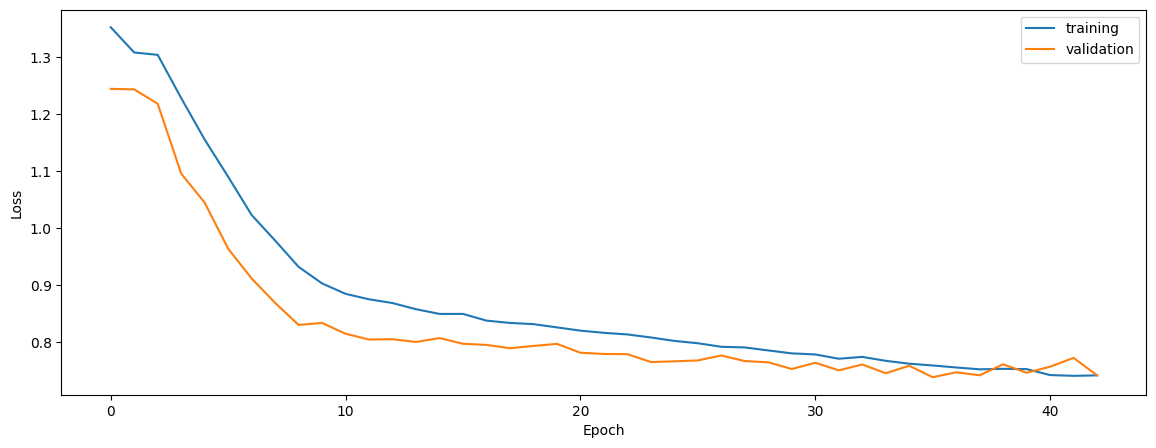

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


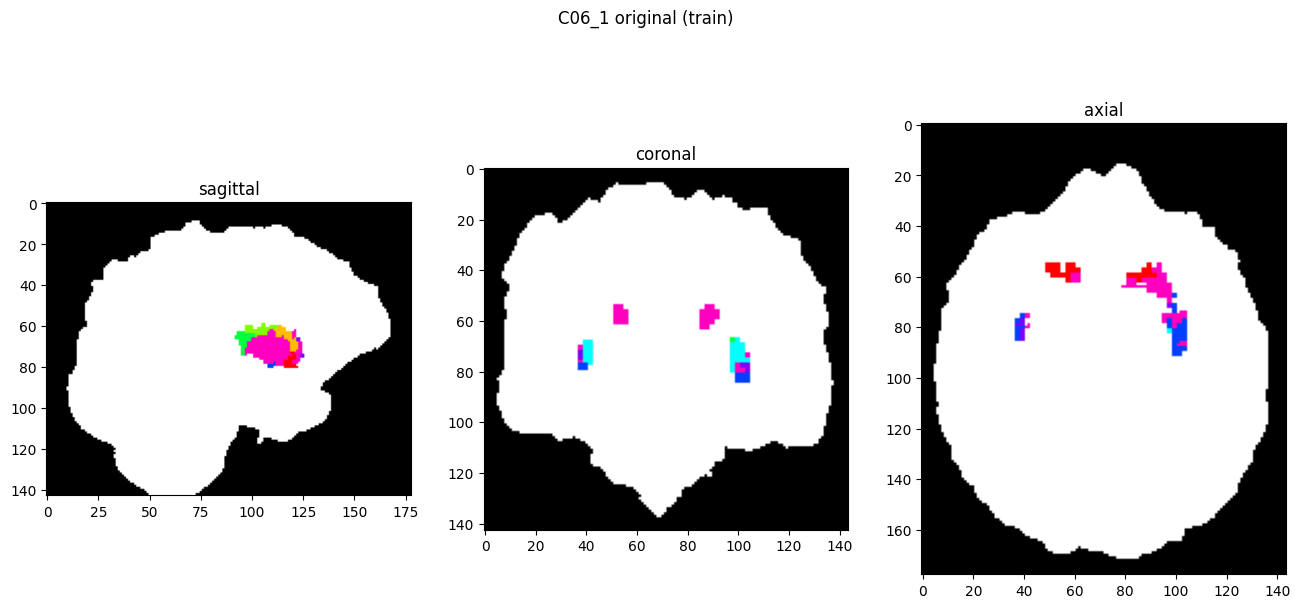

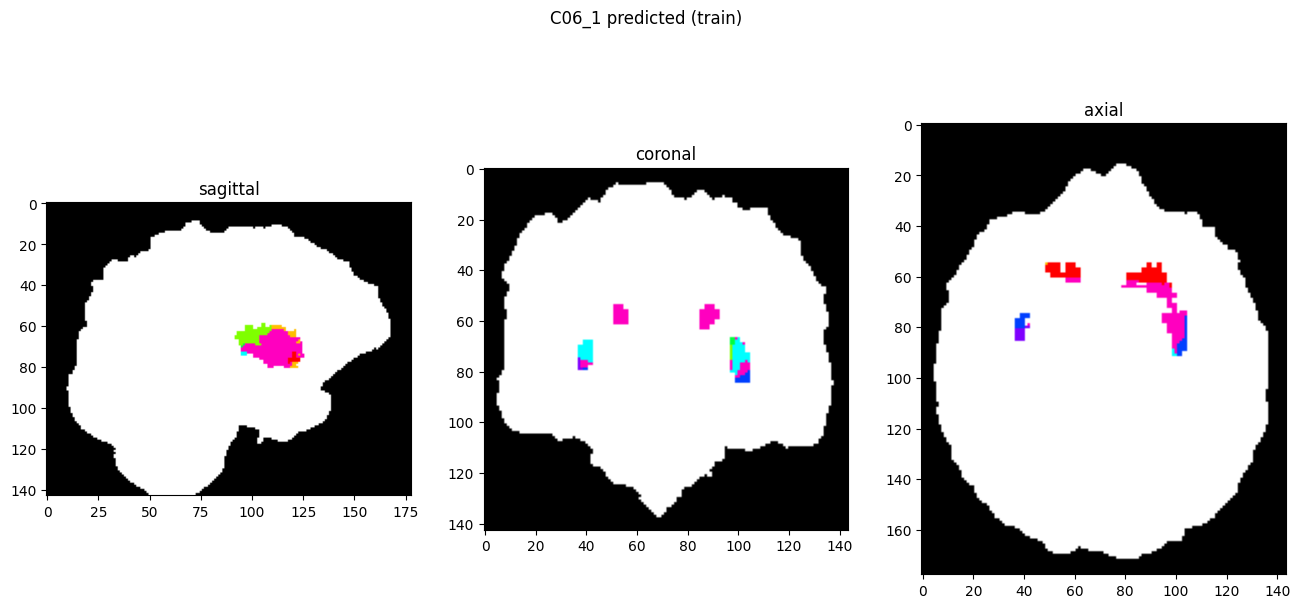

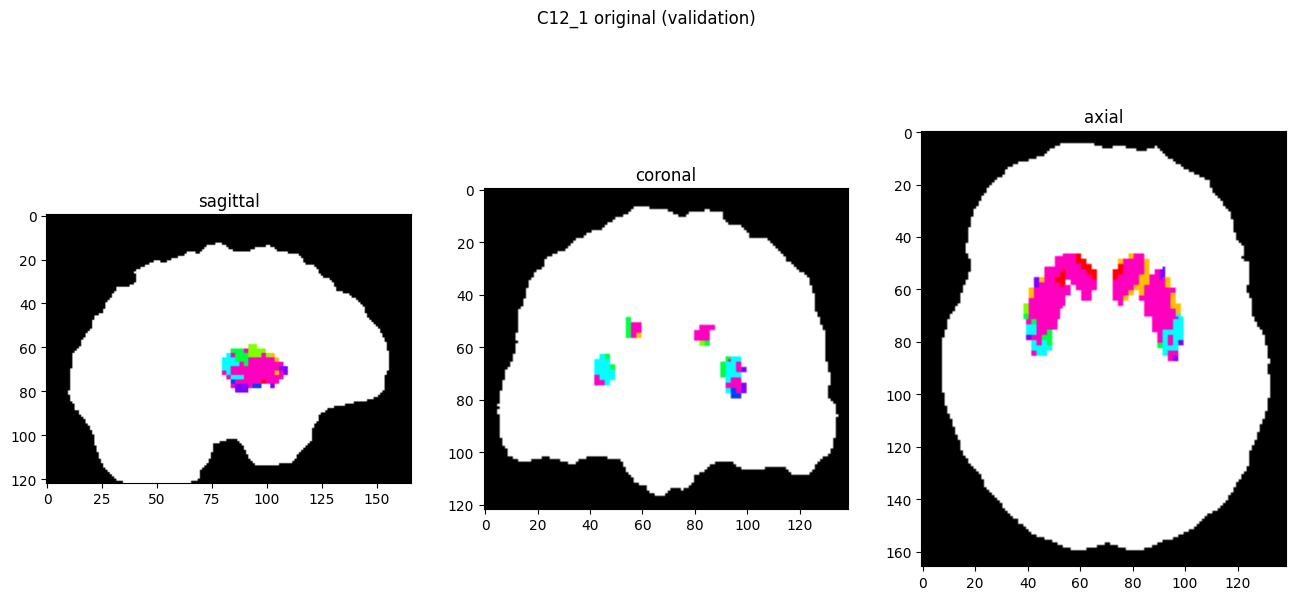

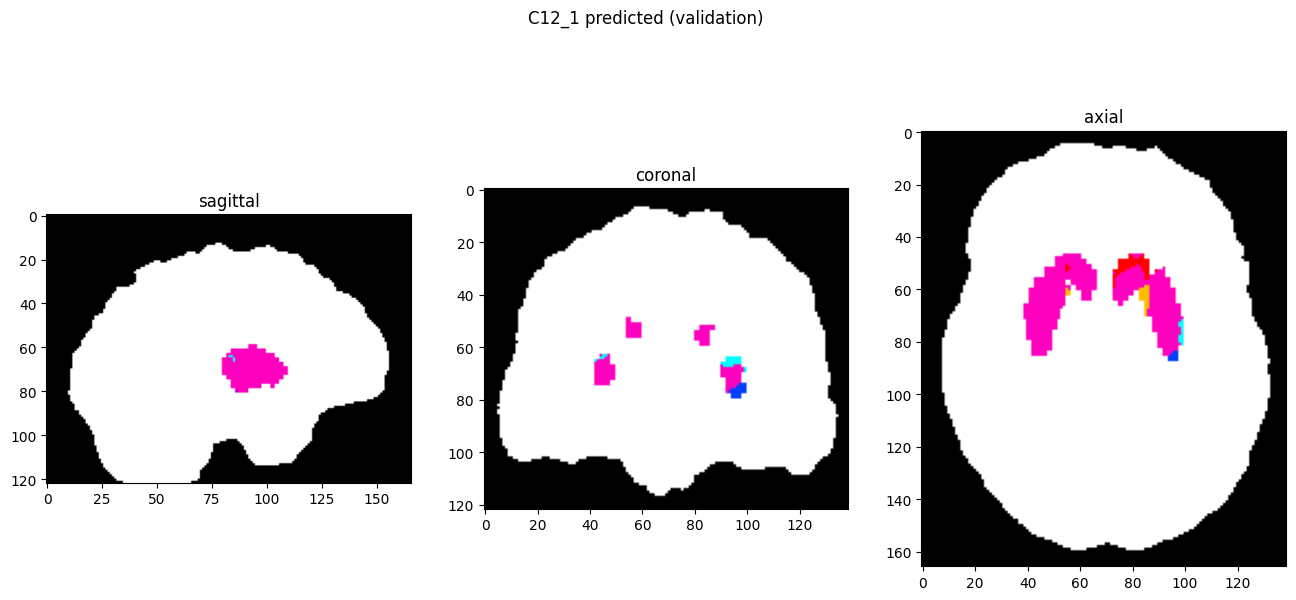

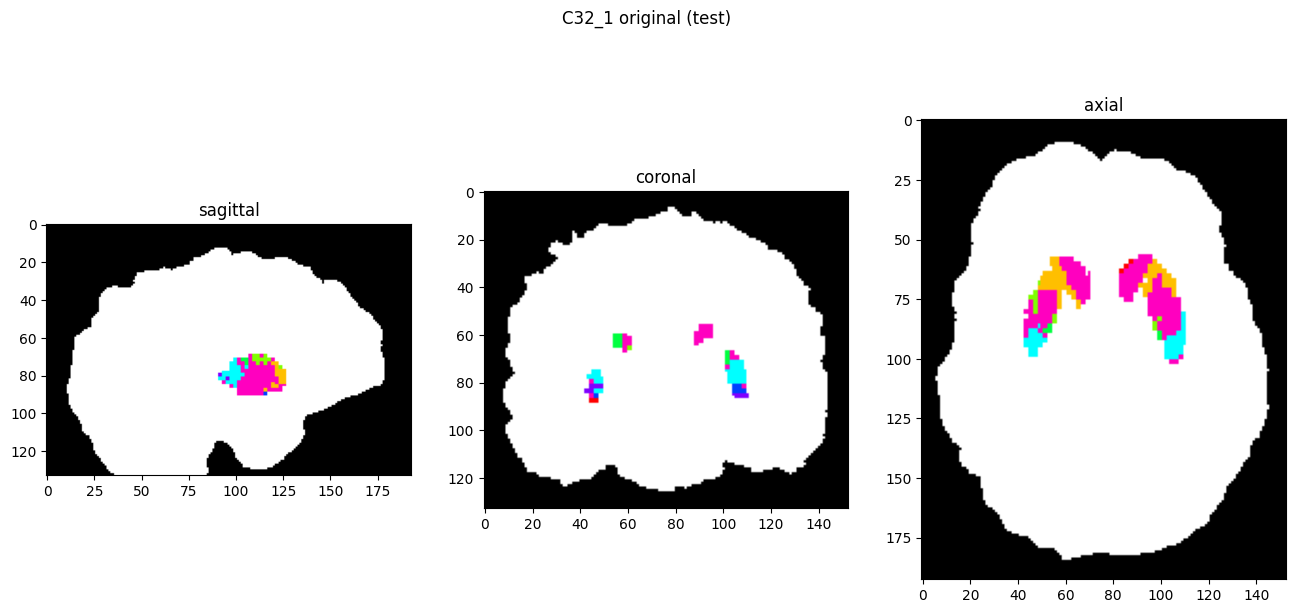

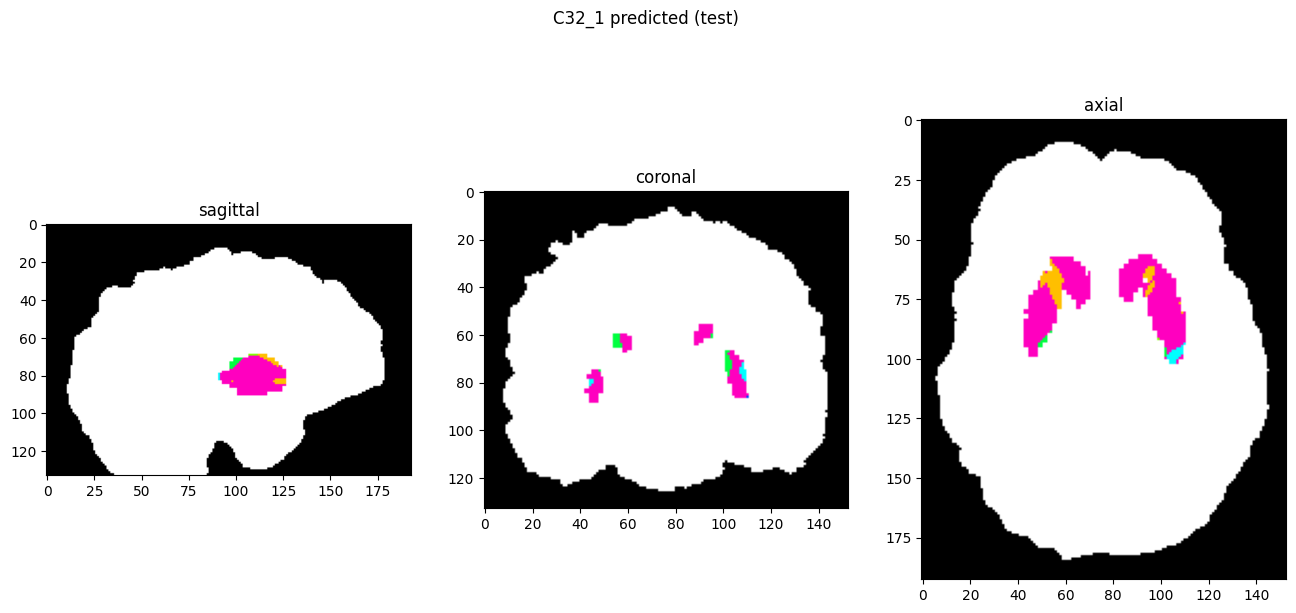

In [10]:
showResults(model, gen, threshold=0)